In [336]:
#Importing all the neseccary libraries

import pandas as pd
import numpy as np
from scipy import stats
from scipy import signal
import datetime as dt
from datetime import timedelta, date

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm

# Part 0 : Import Dataset & Cleansing Data

In [337]:
# STEP 1: Import May , June, July and August
May = pd.read_csv("May.csv",encoding='latin1',sep=';',index_col=0, skiprows=[1],low_memory = False, parse_dates=['date'],dayfirst=True)
June = pd.read_csv("June.csv",encoding='latin1',sep=';',index_col=0,skiprows=[1],low_memory = False, parse_dates=['date'],dayfirst=True)
July = pd.read_csv("July.csv",encoding='latin1',sep=';',index_col=0,skiprows=[1],low_memory = False, parse_dates=['date'],dayfirst=True)
Aug = pd.read_csv("August.csv",encoding='latin1',sep=';',index_col=0,skiprows=[1],low_memory = False, parse_dates=['date'],dayfirst=True)
    
#STEP 2: Remove entries with the indication ERROR
for cols in May.columns:
    May = May[May[cols] != 'ERROR'] # Drop ERROR values and then handle the missing values.
    
# STEP 3: Remove noise entries  at fan_speed
    
#print(July.dtypes[July.dtypes  != 'float64'])
#July['main_fan_speed_rpm_pv'].value_counts().head(10)
July = July[~July['main_fan_speed_rpm_pv'].str.contains('.000.000',na=False)]
July = July[~July['fan_speed_rpm_pv'].str.contains('.000.000',na=False)]

# STEP 4: Cast  variables to float
May[May.columns[2:]] = May[May.columns[2:]].astype(float)
July[July.columns[2:]] = July[July.columns[2:]].astype(float)
    
# STEP 5: Reforming the columns names of the dataframes
Aug= Aug.drop(Aug.columns[95:],axis=1)

desired_column_names = Aug.columns

May.columns = desired_column_names

June.columns = desired_column_names

July2 = July.iloc[:,95:-5]
July = July.drop(July.columns[95:],axis=1)
July.columns = desired_column_names

# Fill Na values of one column with the values from the values of their "copy"
for cols in July2.columns:
    July[cols].fillna(July2[cols],inplace=True)
    
# STEP 6: Concatenate Dataframes
all_data = pd.concat([May, June, July,Aug])
desired_features =['date','total_feed_ton_h_pv' ,'mill_motor_pwr_kw_pv','separator_speed_rpm_pv','mill_dp_mbar_pv',
                   'separator_pwr_kw_pv','fly_ash_1_perc_pv','fly_ash_2_perc_pv',
                   'fan_speed_rpm_pv','grinding_pressure_bar_pv','mill_injection_water_m3_h_pv',
                   'bucket_elv_mtr_pwr_kw_pv','fly_ash_1_ton_h_pv']

all_data = all_data[desired_features]

all_data = all_data.dropna() # dropna to the desired features not all the df

In [338]:
all_data.head()

,date,total_feed_ton_h_pv,mill_motor_pwr_kw_pv,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv,fly_ash_1_perc_pv,fly_ash_2_perc_pv,fan_speed_rpm_pv,grinding_pressure_bar_pv,mill_injection_water_m3_h_pv,bucket_elv_mtr_pwr_kw_pv,fly_ash_1_ton_h_pv
4560,2019-05-10 11:07:30,85.82,1075.47,747.14,31.17,56.13,31.00,0.07,928.2,115.0,2.69,4.88,26.65
5030,2019-05-10 11:12:00,85.50,1190.14,746.87,31.37,56.83,30.60,0.09,928.2,116.0,2.69,4.83,26.34
6277,2019-05-10 11:24:00,57.92,1046.61,717.51,29.79,60.41,0.05,0.15,928.2,123.0,2.45,4.82,0.01
6332,2019-05-10 11:24:30,57.72,1023.69,735.89,30.51,55.76,0.00,0.15,928.2,120.0,2.46,4.85,0.00
6388,2019-05-10 11:25:00,58.01,1024.23,736.68,31.61,55.89,0.03,0.14,928.2,118.0,2.46,4.88,0.01


# Part 1: Timeseries & Normal Conditions

In [339]:
# STEP 2: Timeseries manipulation

all_data = all_data.set_index("date")

#From the duplicates keep the first and the last sample
all_data.groupby(all_data.index).nth([0, -1])

#Change the last duplicate with the appropriate timestamp
is_duplicate  = all_data.index.duplicated(keep='last')
all_data.index = all_data.index.where(is_duplicate,all_data.index+dt.timedelta(0,30))

# For the rest duplicate dates take the mean
all_data = all_data.groupby(['date']).mean()
    
# STEP 3: Normal Conditions
    
#The values of the normal condition was produced according to the plots(scaterplots-distributions) below
msk1 = all_data['mill_motor_pwr_kw_pv'] > 600  
msk2 = all_data['total_feed_ton_h_pv'] >  40 

data = all_data[ msk1 & msk2]

block1 = data[['separator_speed_rpm_pv','mill_dp_mbar_pv','separator_pwr_kw_pv']]
block2 = data[['total_feed_ton_h_pv','fly_ash_1_perc_pv','fly_ash_2_perc_pv','fan_speed_rpm_pv','separator_speed_rpm_pv',
                'grinding_pressure_bar_pv','mill_injection_water_m3_h_pv','bucket_elv_mtr_pwr_kw_pv','mill_dp_mbar_pv']]

# Outliers with Z-score 
msk1 = (np.abs(stats.zscore(block1)) <5).all(axis=1)
msk2 = (np.abs(stats.zscore(block2)) <5).all(axis=1)

block1 = block1[msk1]
block2 = block2[msk2]

(0.0, 2000.0)

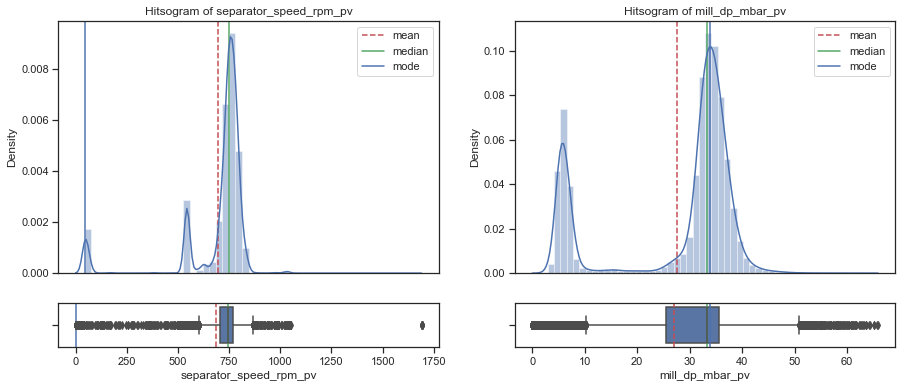

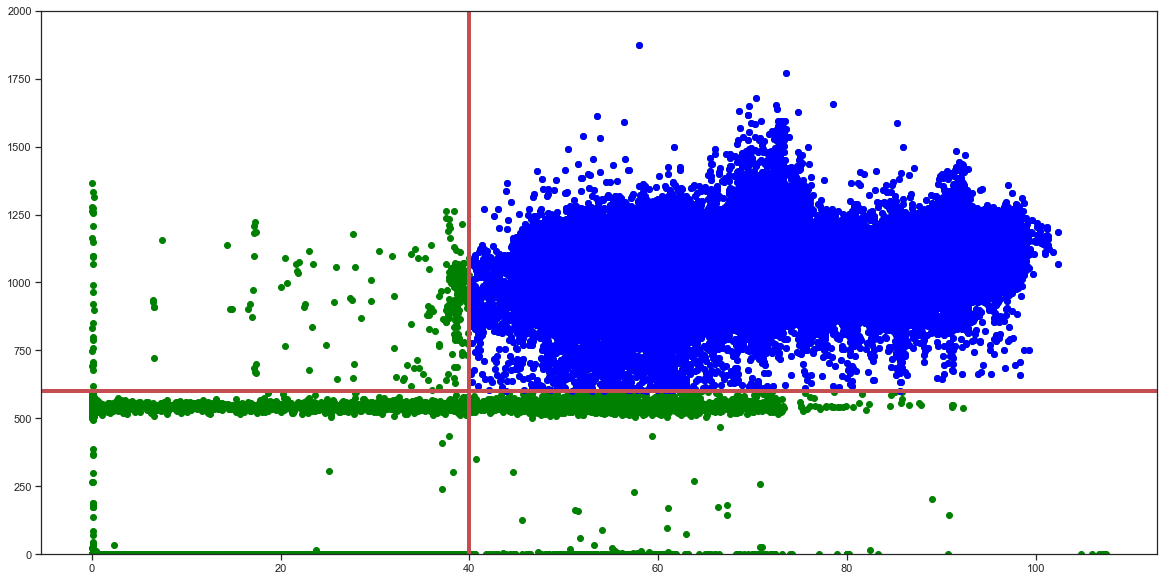

In [340]:
sns.set(style="ticks")

attributes = ['separator_speed_rpm_pv' ,'mill_dp_mbar_pv']

f, axes = plt.subplots(nrows = 2, ncols = len(attributes), gridspec_kw={"height_ratios": (.85, .15)},figsize=(8,6) )
f.set_figwidth(15)

for i, att in enumerate(attributes):

    mean = all_data[att].mean()
    median = all_data[att].median()
    mode = all_data[att].mode().values[0]
    
    axes[0][i].axvline(mean, color='r', linestyle='--' , label ='mean')
    axes[0][i].axvline(median, color='g', linestyle='-', label ='median')
    axes[0][i].axvline(mode, color='b', linestyle='-', label = 'mode')
    axes[0][i].xaxis.set_visible(False)
    axes[0][i].legend()
    axes[0][i].set_title('Hitsogram of '+ att)
    axes[1][i].axvline(mean, color='r', linestyle='--', label ='mean')
    axes[1][i].axvline(median, color='g', linestyle='-', label ='median')
    axes[1][i].axvline(mode, color='b', linestyle='-', label = 'mode')

    sns.distplot(all_data[att], ax = axes[0][i])
    sns.boxplot(all_data[att], ax = axes[1][i])

    
plt.figure(figsize=(20,10))
plt.scatter(all_data['total_feed_ton_h_pv'],all_data['mill_motor_pwr_kw_pv'],color='green')
plt.scatter(data['total_feed_ton_h_pv'],data['mill_motor_pwr_kw_pv'],color='blue')
plt.axhline(y = 600, color = 'r', linewidth = 4, linestyle = '-')

x = [40]
y = [2500]
markerline, stemlines, baseline = plt.stem(x, y, linefmt = 'r')
plt.setp(stemlines, 'linewidth', 4)

plt.ylim(0,2000)

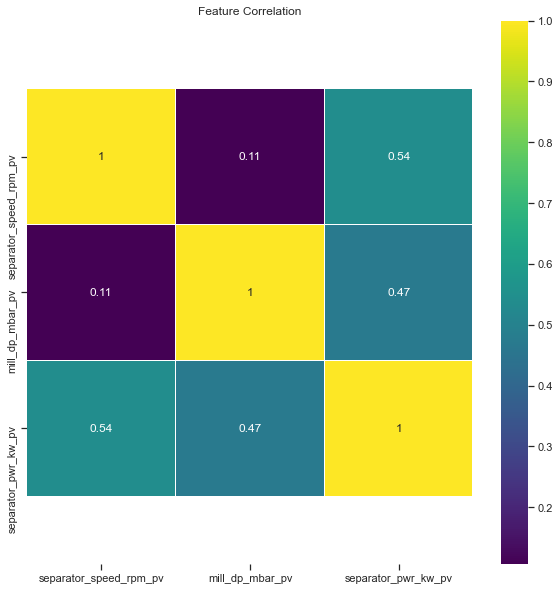

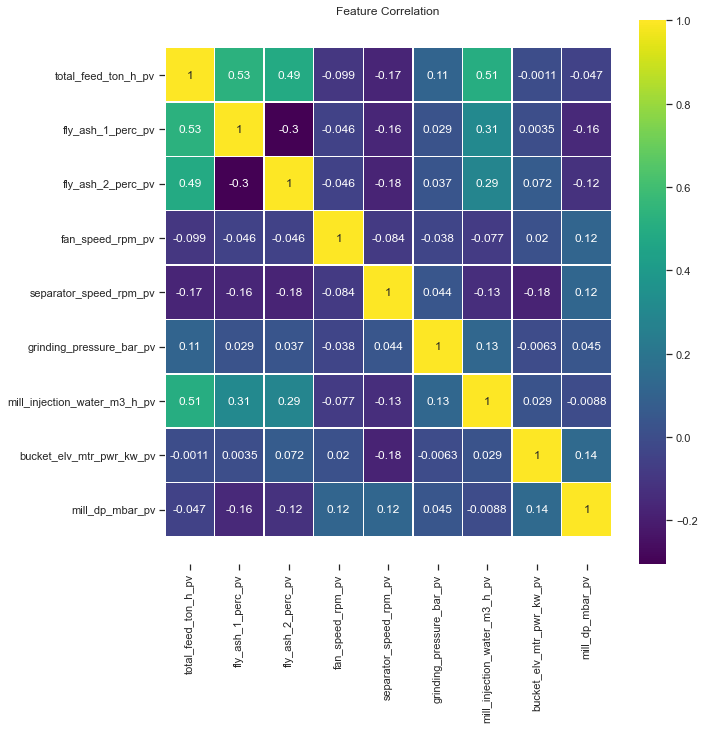

In [341]:
#/////// Correlation/////////
#////Block1////
corr = block1.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, linewidths=.5, cmap='viridis')
plt.title("Feature Correlation")
b, t = plt.ylim()
plt.ylim(b+0.5, t-0.5)
plt.show()


#//// Block 2 /////
corr = block2.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, linewidths=.5, cmap='viridis')
plt.title("Feature Correlation")
b, t = plt.ylim()
plt.ylim(b+0.5, t-0.5)
plt.show()

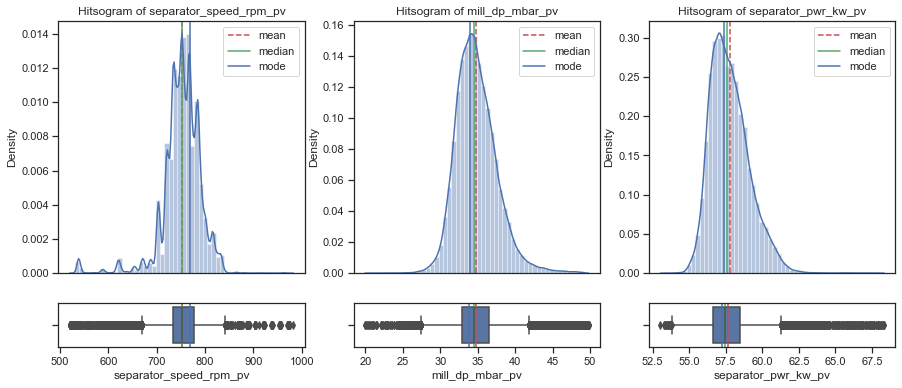

In [342]:
#

sns.set(style="ticks")

attributes = block1.columns

f, axes = plt.subplots(nrows = 2, ncols = len(attributes), gridspec_kw={"height_ratios": (.85, .15)},figsize=(8,6) )
f.set_figwidth(15)

for i, att in enumerate(attributes):

    mean = block1[att].mean()
    median = block1[att].median()
    mode = block1[att].mode().values[0]

    axes[0][i].axvline(mean, color='r', linestyle='--' , label ='mean')
    axes[0][i].axvline(median, color='g', linestyle='-', label ='median')
    axes[0][i].axvline(mode, color='b', linestyle='-', label = 'mode')
    axes[0][i].xaxis.set_visible(False)
    axes[0][i].legend()
    axes[0][i].set_title('Hitsogram of '+ att)
    axes[1][i].axvline(mean, color='r', linestyle='--', label ='mean')
    axes[1][i].axvline(median, color='g', linestyle='-', label ='median')
    axes[1][i].axvline(mode, color='b', linestyle='-', label = 'mode')

    sns.distplot(block1[att], ax = axes[0][i])
    sns.boxplot(block1[att], ax = axes[1][i])

In [343]:
block1.index[0] #Checking if date is index

Timestamp('2019-05-10 11:08:00')

In [344]:
print(block1.shape)
print(block2.shape)

(196127, 3)
(194667, 9)


In [345]:
# //////////// Find the longest continuous part of the timeseries ////////////////////
#//////Block1///////

i0max, i1max = 0, 0
i0 = 0
for i1, date in enumerate(block1.index):
    if date - block1.index[i0] != np.timedelta64(i1-i0, '30s'):
        if i1 - i0 > i1max - i0max:
            i0max, i1max = i0, i1
        i0 = i1

print(block1.index[i0max])
print(block1.index[i1max],"\n")

#///////Block2///////

i0max, i1max = 0, 0
i0 = 0
for i1, date in enumerate(block2.index):
    if date - block2.index[i0] != np.timedelta64(i1-i0, '30s'):
        if i1 - i0 > i1max - i0max:
            i0max, i1max = i0, i1
        i0 = i1

print(block2.index[i0max])
print(block2.index[i1max],"\n")

print(block2.index[i1max]-block2.index[i0max])

2019-07-18 20:30:30
2019-07-19 04:42:30 

2019-07-18 20:30:30
2019-07-19 04:42:30 

0 days 08:12:00


#### As we can see the edges of the longest parts of Block1 and Block2 are the same. 

#### So the longest part of the timeseries is 8 hours and 12 minutes on July in 2019

In [346]:
#/////// Printing the shapes of the datasets of the longest part of the timeseries ///////////

block1_con = block1["2019/07/18 20:30:30":"2019/07/19 04:42:30"]
block2_con = block2["2019/07/18 20:30:30":"2019/07/19 04:42:30"]

print(block1_con.shape)
print(block2_con.shape)

(984, 3)
(984, 9)


In [347]:
block1_con.head()

,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv
date,,,
2019-07-18 20:30:30,731.56,32.58,56.60
2019-07-18 20:31:00,730.77,32.81,56.21
2019-07-18 20:31:30,730.98,32.51,56.02
2019-07-18 20:32:00,731.14,32.72,56.17
2019-07-18 20:32:30,730.87,32.56,56.01


In [348]:
block2_con.head()

,total_feed_ton_h_pv,fly_ash_1_perc_pv,fly_ash_2_perc_pv,fan_speed_rpm_pv,separator_speed_rpm_pv,grinding_pressure_bar_pv,mill_injection_water_m3_h_pv,bucket_elv_mtr_pwr_kw_pv,mill_dp_mbar_pv
date,,,,,,,,,
2019-07-18 20:30:30,90.79,0.02,29.21,940.1,731.56,120.0,2.85,4.92,32.58
2019-07-18 20:31:00,90.79,0.00,29.33,940.1,730.77,117.0,2.84,4.95,32.81
2019-07-18 20:31:30,90.37,0.01,29.07,940.1,730.98,115.0,2.85,4.92,32.51
2019-07-18 20:32:00,90.50,0.02,29.03,940.1,731.14,121.0,2.84,4.90,32.72
2019-07-18 20:32:30,90.79,0.01,29.03,940.1,730.87,120.0,2.84,4.95,32.56


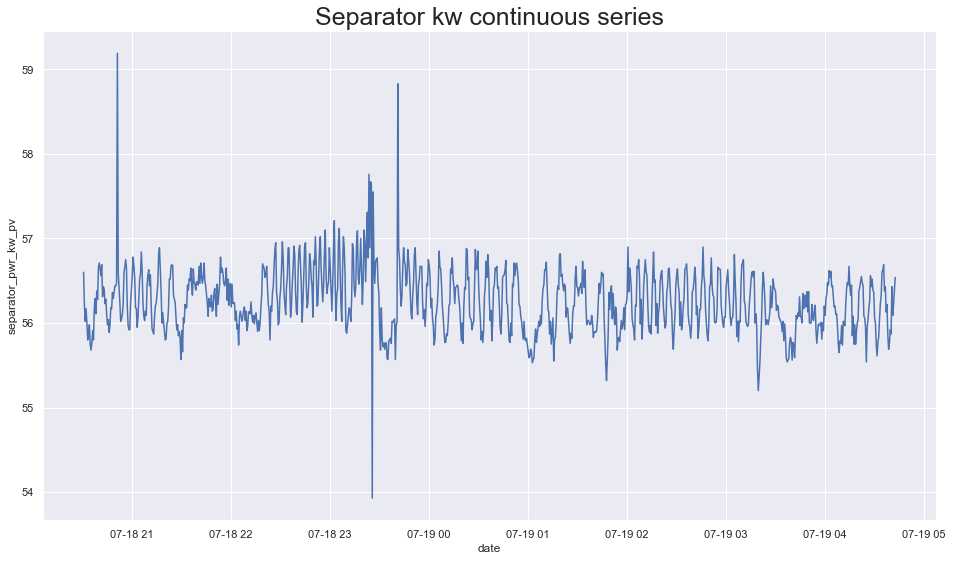

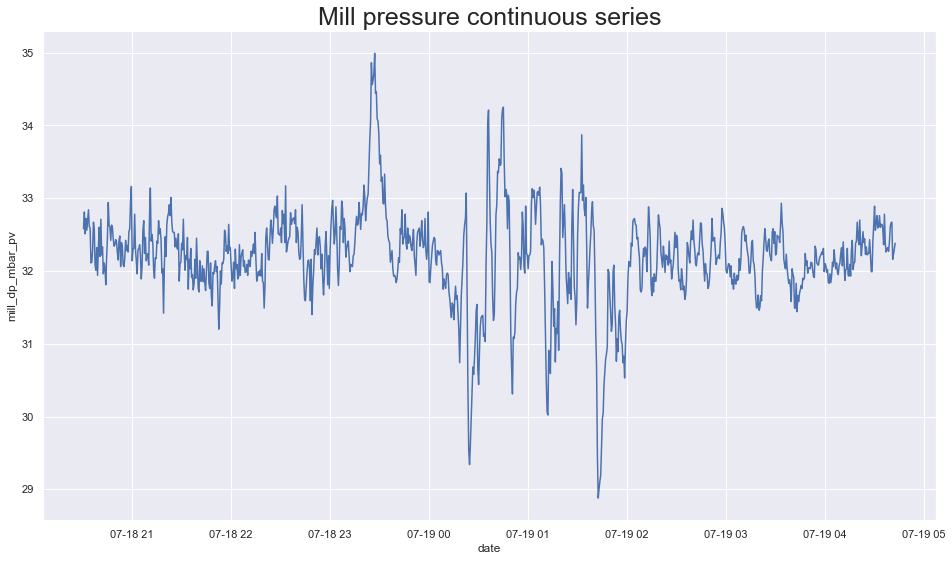

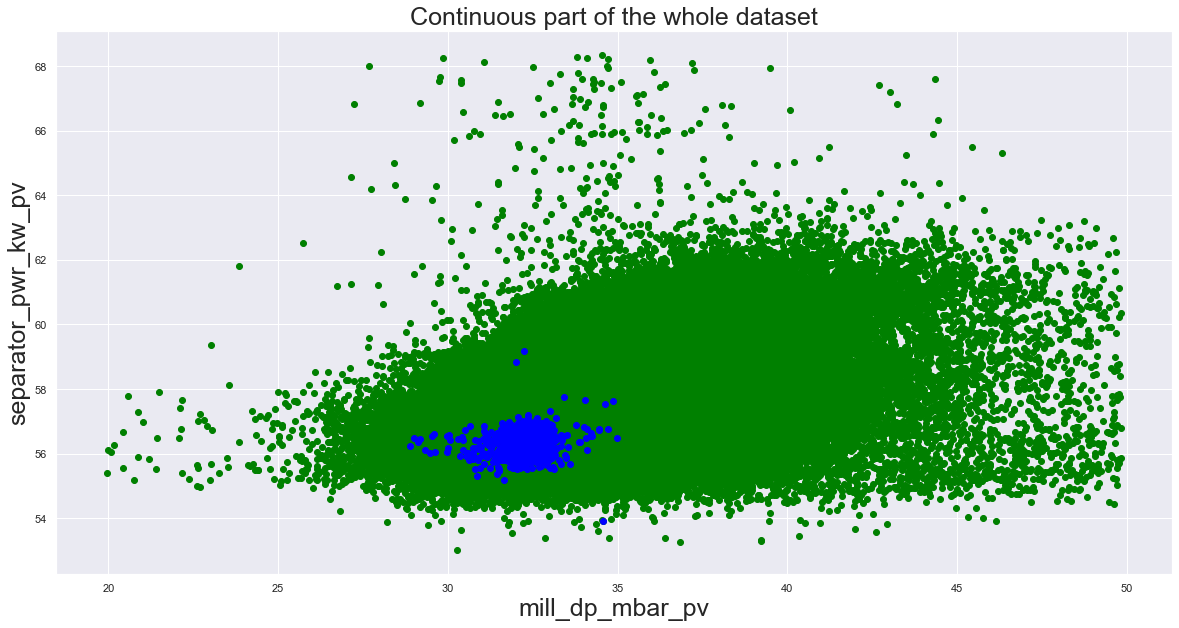

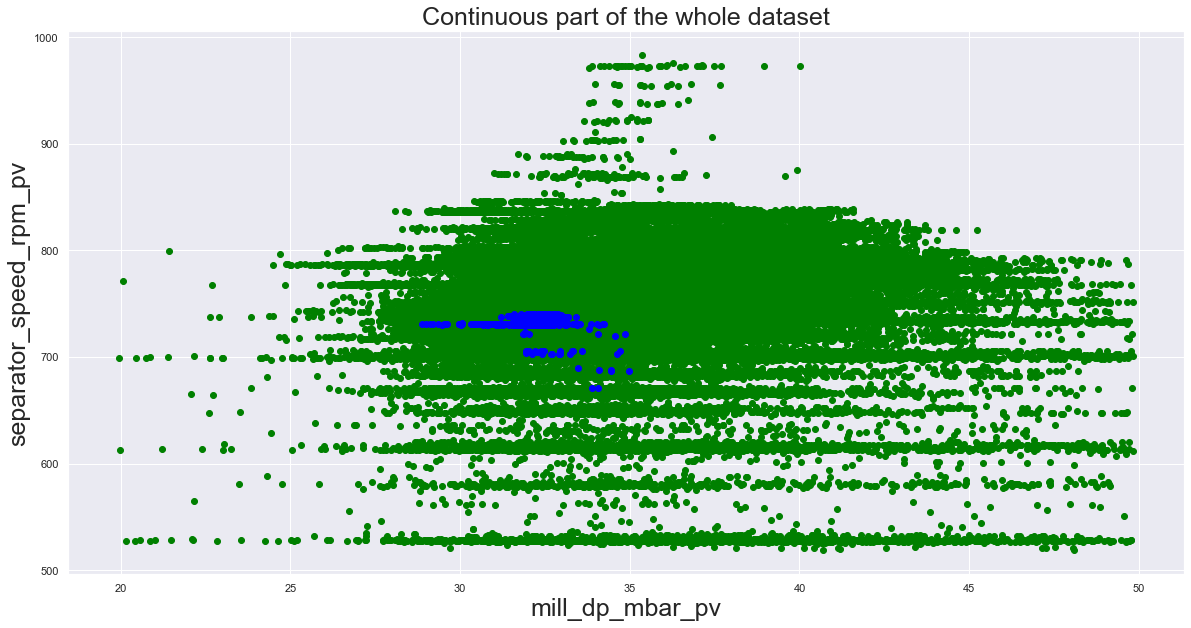

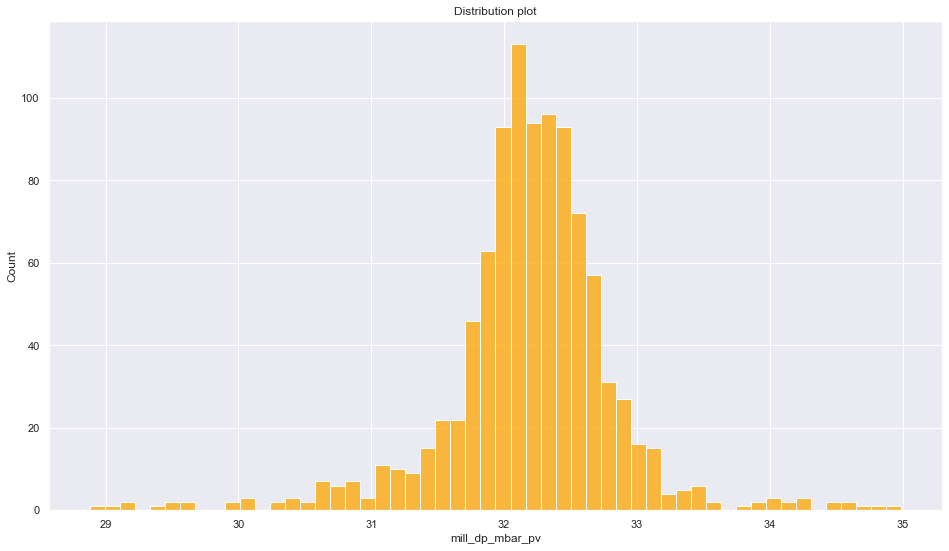

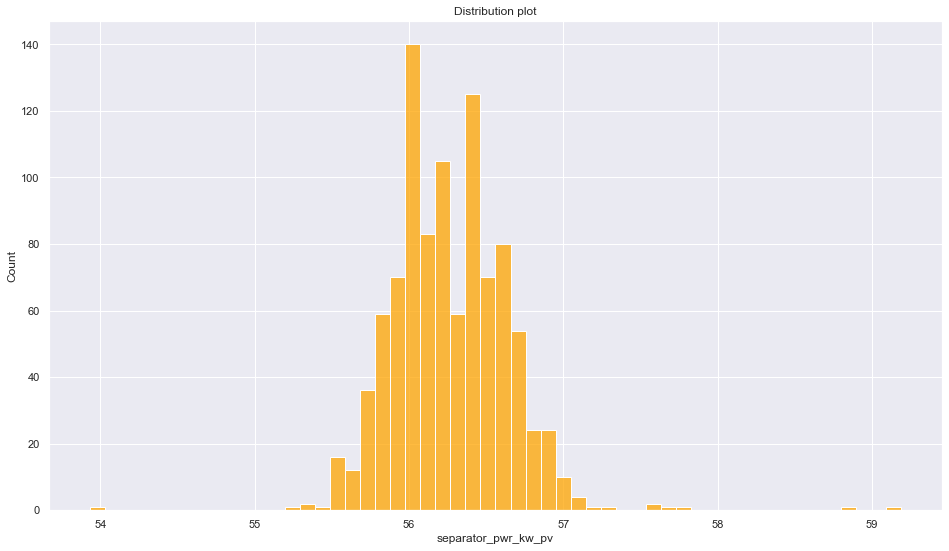

In [349]:
#///// Continuous Block1 target plot /////
sns.set_theme(style="darkgrid")
sns.lineplot(x=block1_con.index, y="separator_pwr_kw_pv", data=block1_con)
plt.title("Separator kw continuous series", fontsize= 25)
plt.show()

# ///// Continuous Block2 target plot //////
sns.set_theme(style="darkgrid")
sns.lineplot(x=block2_con.index, y="mill_dp_mbar_pv", data=block2_con)
plt.title("Mill pressure continuous series", fontsize= 25)
plt.show()

#/////Scatterplots of continious Block1 and Block2 VS  non-continuous//////
plt.figure(figsize=(20,10))
ax = plt.gca()
plt.scatter(block1['mill_dp_mbar_pv'],block1['separator_pwr_kw_pv'],color='green')
plt.scatter(block1_con['mill_dp_mbar_pv'],block1_con['separator_pwr_kw_pv'],color='blue')
plt.xlabel("mill_dp_mbar_pv", fontsize= 25)
plt.ylabel('separator_pwr_kw_pv', fontsize= 25)
plt.title("Continuous part of the whole dataset", fontsize= 25)
plt.show()
    
plt.figure(figsize=(20,10))
ax = plt.gca()
plt.scatter(block1['mill_dp_mbar_pv'],block1['separator_speed_rpm_pv'],color='green')
plt.scatter(block1_con['mill_dp_mbar_pv'],block1_con['separator_speed_rpm_pv'],color='blue')
plt.xlabel("mill_dp_mbar_pv", fontsize= 25)
plt.ylabel('separator_speed_rpm_pv', fontsize= 25)
plt.title("Continuous part of the whole dataset", fontsize= 25)
plt.show()

for i in ["mill_dp_mbar_pv", "separator_pwr_kw_pv"]:
    sns.set(style = 'darkgrid', palette= 'muted')
    sns.histplot(block1_con[i], kde=False, color="orange")
    plt.title("Distribution plot")
    plt.show()

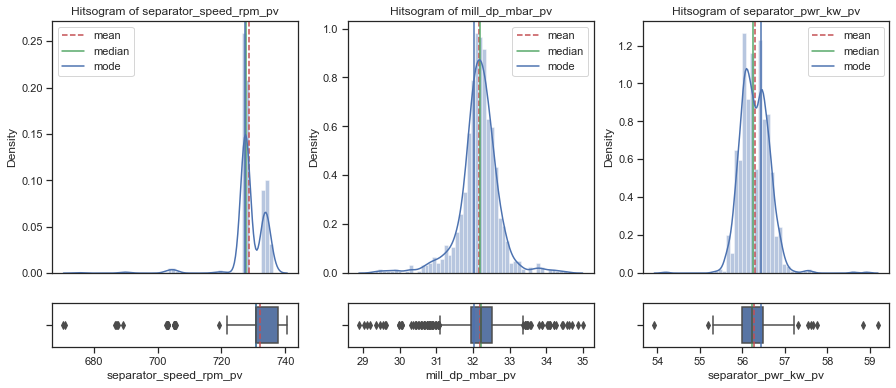

In [350]:
#

sns.set(style="ticks")

attributes = block1_con.columns

f, axes = plt.subplots(nrows = 2, ncols = len(attributes), gridspec_kw={"height_ratios": (.85, .15)},figsize=(8,6) )
f.set_figwidth(15)

for i, att in enumerate(attributes):

    mean = block1_con[att].mean()
    median = block1_con[att].median()
    mode = block1_con[att].mode().values[0]

    axes[0][i].axvline(mean, color='r', linestyle='--' , label ='mean')
    axes[0][i].axvline(median, color='g', linestyle='-', label ='median')
    axes[0][i].axvline(mode, color='b', linestyle='-', label = 'mode')
    axes[0][i].xaxis.set_visible(False)
    axes[0][i].legend()
    axes[0][i].set_title('Hitsogram of '+ att)
    axes[1][i].axvline(mean, color='r', linestyle='--', label ='mean')
    axes[1][i].axvline(median, color='g', linestyle='-', label ='median')
    axes[1][i].axvline(mode, color='b', linestyle='-', label = 'mode')

    sns.distplot(block1_con[att], ax = axes[0][i])
    sns.boxplot(block1_con[att], ax = axes[1][i])

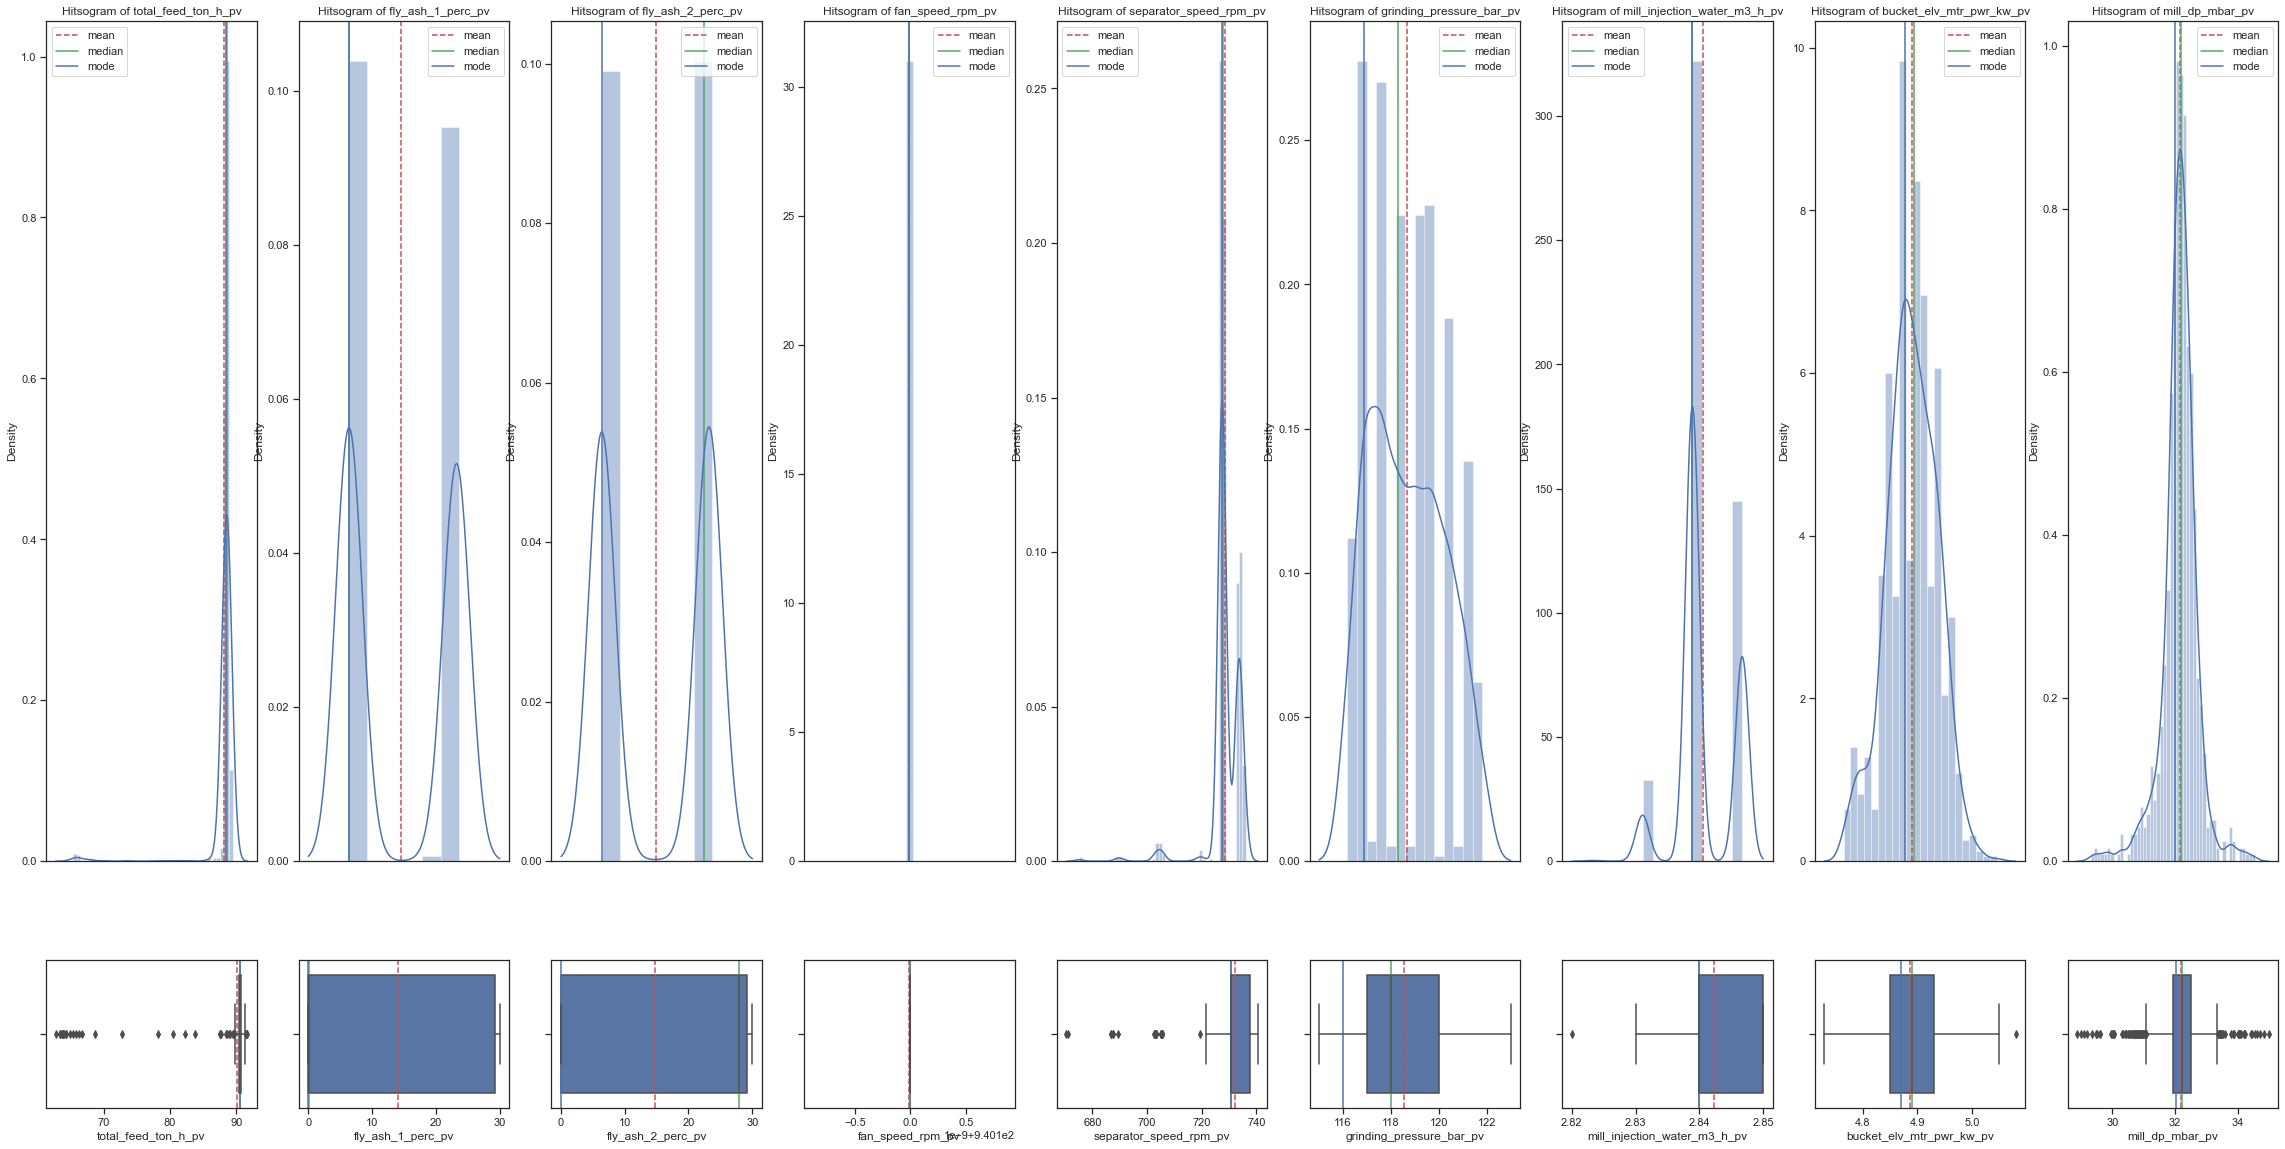

In [351]:
sns.set(style="ticks")

attributes = block2_con.columns

f, axes = plt.subplots(nrows = 2, ncols = len(attributes), gridspec_kw={"height_ratios": (.85, .15)},figsize=(10,20) )
f.set_figwidth(40)

for i, att in enumerate(attributes):

    mean = block2_con[att].mean()
    median = block2_con[att].median()
    mode = block2_con[att].mode().values[0]

    axes[0][i].axvline(mean, color='r', linestyle='--' , label ='mean')
    axes[0][i].axvline(median, color='g', linestyle='-', label ='median')
    axes[0][i].axvline(mode, color='b', linestyle='-', label = 'mode')
    axes[0][i].xaxis.set_visible(False)
    axes[0][i].legend()
    axes[0][i].set_title('Hitsogram of '+ att)
    axes[1][i].axvline(mean, color='r', linestyle='--', label ='mean')
    axes[1][i].axvline(median, color='g', linestyle='-', label ='median')
    axes[1][i].axvline(mode, color='b', linestyle='-', label = 'mode')

    sns.distplot(block2_con[att], ax = axes[0][i])
    sns.boxplot(block2_con[att], ax = axes[1][i])

In [407]:
#//////// Checking for stationarity in Block1 continuous series ////////

block1_contest = adfuller(block1_con["separator_pwr_kw_pv"], autolag="AIC", regression="nc")

print("1. ADF ", block1_contest[0])
print("1. P-value ", block1_contest[1])
print("1. Num of Lags ", block1_contest[2])
print("1. Num of observations used for ADF Regression and Critical values calculation ", block1_contest[3])
print("1. Critical values ", block1_contest[0])
for key, val in block1_contest[4].items():
    print("\t",key,": ",val)

1. ADF  0.04807566250985957
1. P-value  0.7000415630131364
1. Num of Lags  16
1. Num of observations used for ADF Regression and Critical values calculation  967
1. Critical values  0.04807566250985957
	 1% :  -2.568055978051287
	 5% :  -1.941281330345538
	 10% :  -1.6165482104381763


### P-value is equal to 1.608^(-9) < 0.05, We can reject the null hypothesis the series is stationary

In [408]:
#//////// Checking for stationarity in Block2 continuous series ////////

block2_contest = adfuller(block2_con["mill_dp_mbar_pv"], autolag="AIC", regression="nc")

print("1. ADF ", block2_contest[0])
print("1. P-value ", block2_contest[1])
print("1. Num of Lags ", block2_contest[2])
print("1. Num of observations used for ADF Regression and Critical values calculation ", block2_contest[3])
print("1. Critical values ", block2_contest[0])
for key, val in block2_contest[4].items():
    print("\t",key,": ",val)

1. ADF  -0.12022245774860697
1. P-value  0.6428750752035759
1. Num of Lags  12
1. Num of observations used for ADF Regression and Critical values calculation  971
1. Critical values  -0.12022245774860697
	 1% :  -2.5680464215493384
	 5% :  -1.941280156934722
	 10% :  -1.6165493183882285


### P-value is equal to 1.194^(-12) < 0.05, We can reject the null hypothesis the series is stationary

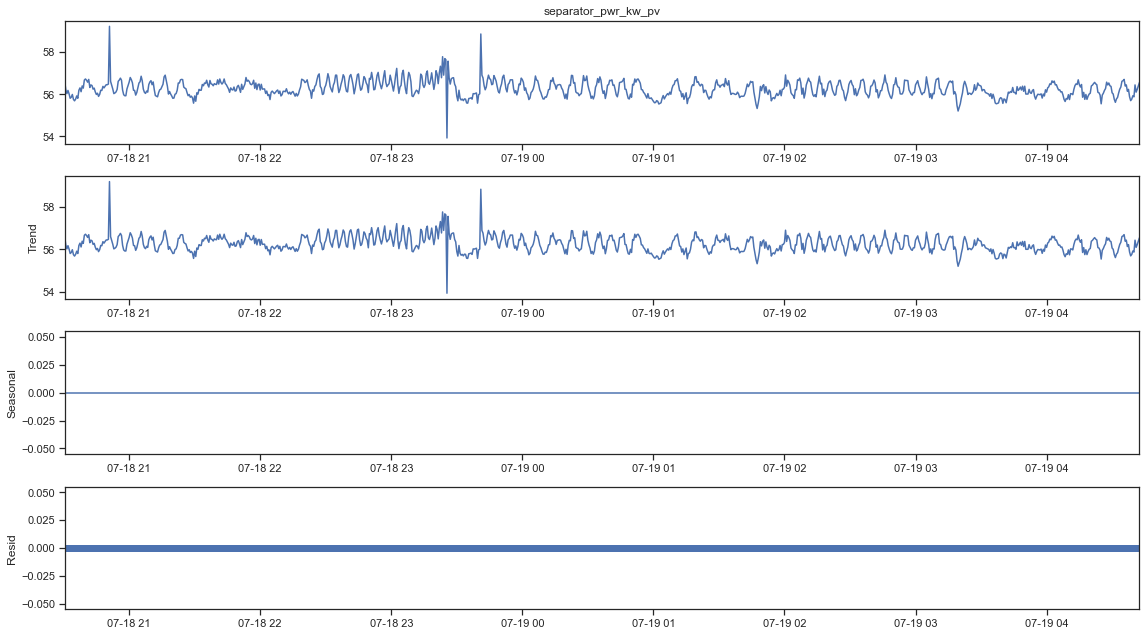

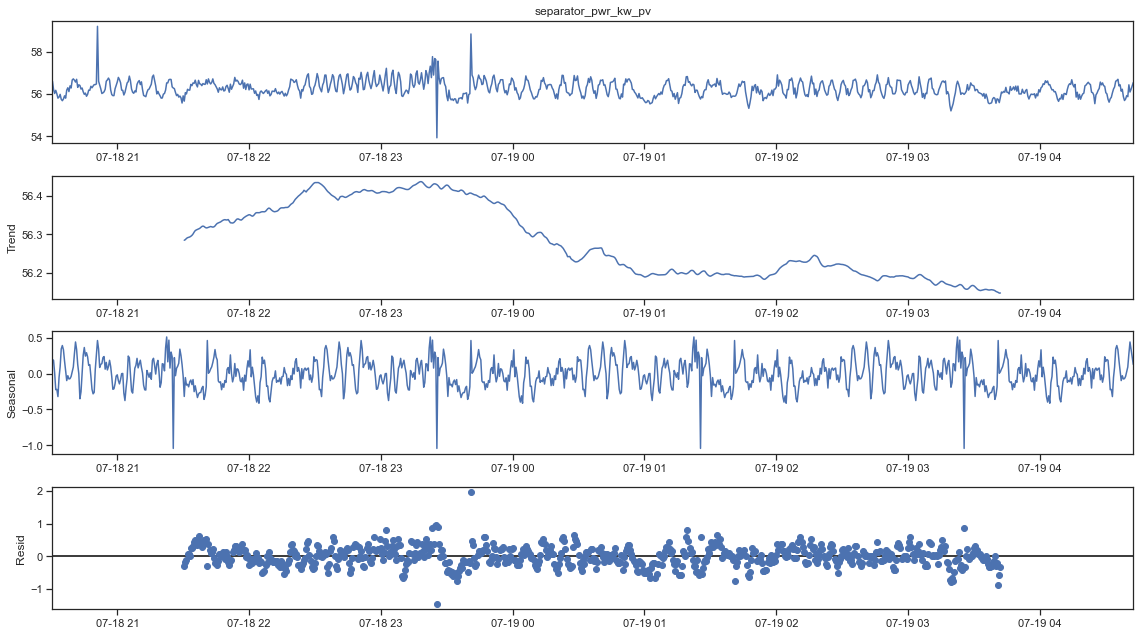

In [398]:
# ///////// Decomposing Block1 continuous series into Trend, Seasonality and the Residuals period=1 ////////

mul_res1 = sm.tsa.seasonal_decompose(block1_con["separator_pwr_kw_pv"],
                                     model="additive",
                                     period=1)
mul_fig1 =mul_res1.plot()

# /////// Decomposing Block1 continuous series into Trend, Seasonality and the Residuals period=... ////////

mul_res2 = sm.tsa.seasonal_decompose(block1_con["separator_pwr_kw_pv"],
                                model="additive",
                                 period=240)
mul_fig2 =mul_res2.plot()

### There is a seasonality every 240 values (120 minutes)

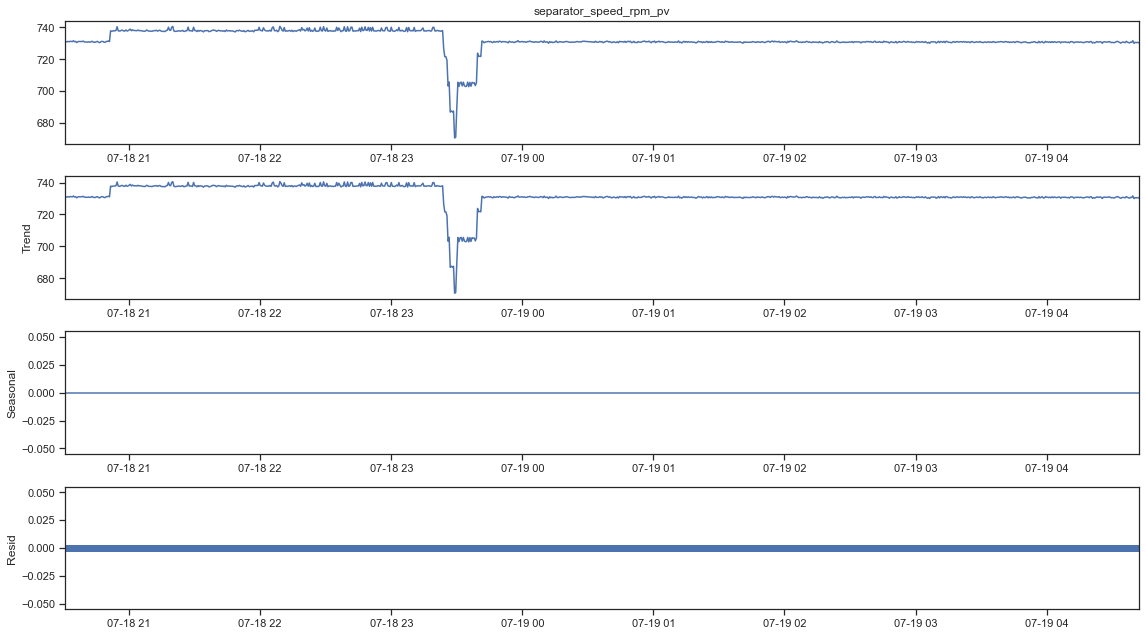

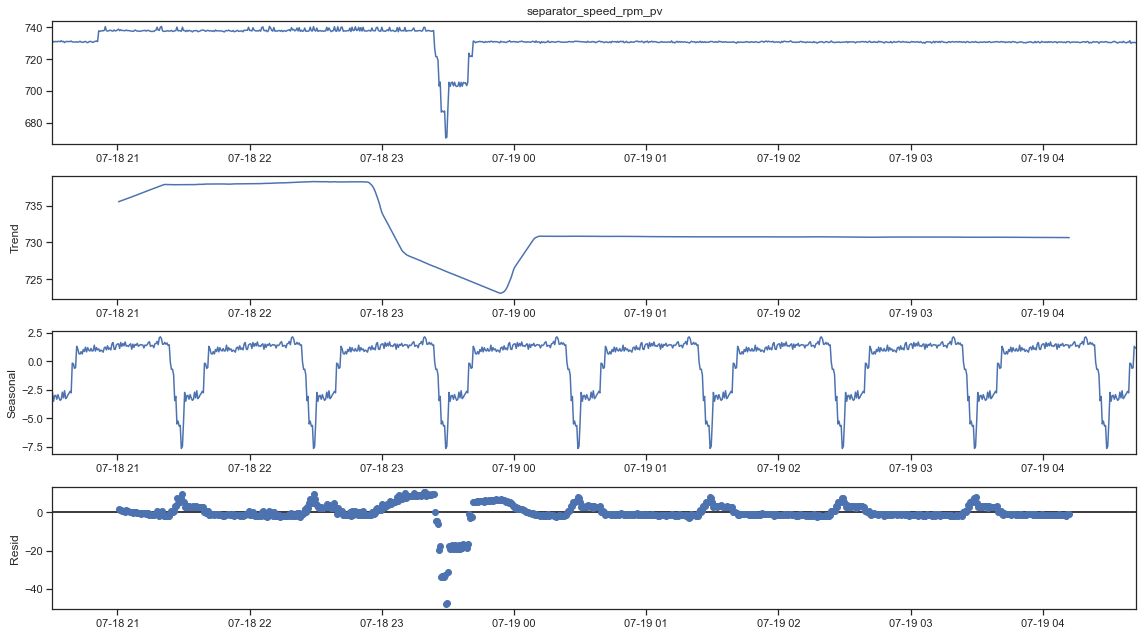

In [394]:
mul_res5 = sm.tsa.seasonal_decompose(block1_con["separator_speed_rpm_pv"],
                                model="additive",
                               period=1)
mul_fig5 =mul_res5.plot()

mul_res6 = sm.tsa.seasonal_decompose(block1_con["separator_speed_rpm_pv"],
                                model="additive",
                               period=120)
mul_fig6 =mul_res6.plot()

#### Every 120 values there is seasonality (60 minutes)

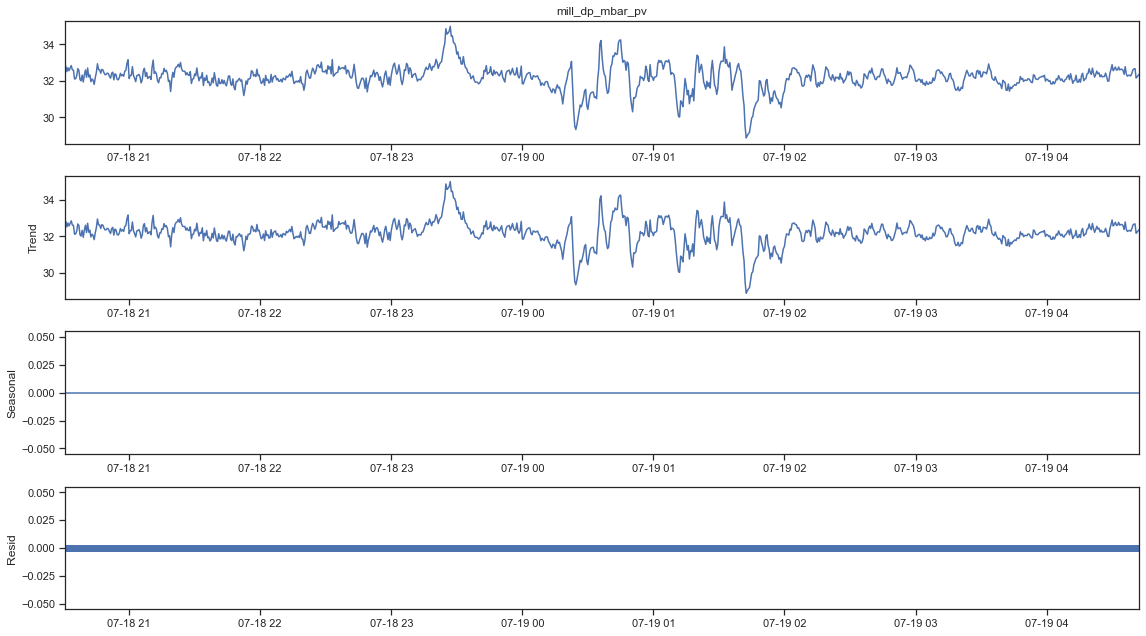

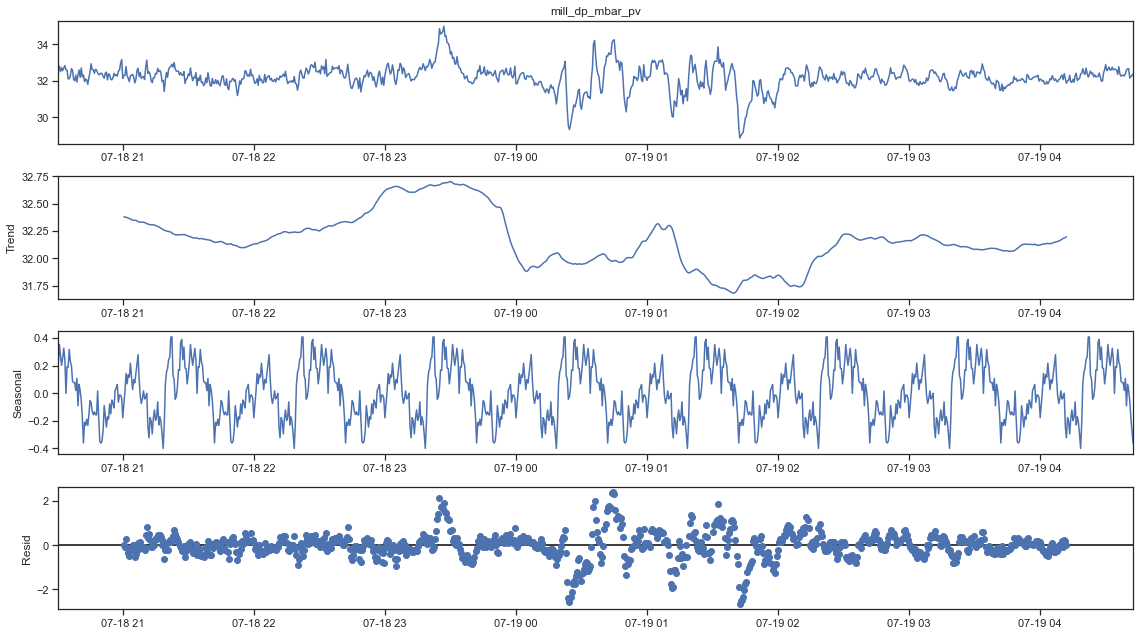

In [404]:
# ///////// Decomposing Block2 continuous series into Trend, Seasonality and the Residuals period=1 ///////

mul_res3 = sm.tsa.seasonal_decompose(block2_con["mill_dp_mbar_pv"],
                                model="additive",
                               period=1)
mul_fig3 =mul_res3.plot()

# /////// Decomposing Block2 continuous series into Trend, Seasonality and the Residuals period=... //////

mul_res4 = sm.tsa.seasonal_decompose(block2_con["mill_dp_mbar_pv"],
                                model="additive",
                               period=120)
mul_fig4 =mul_res4.plot()

### There is a seasonality every 120 values (60 minutes)

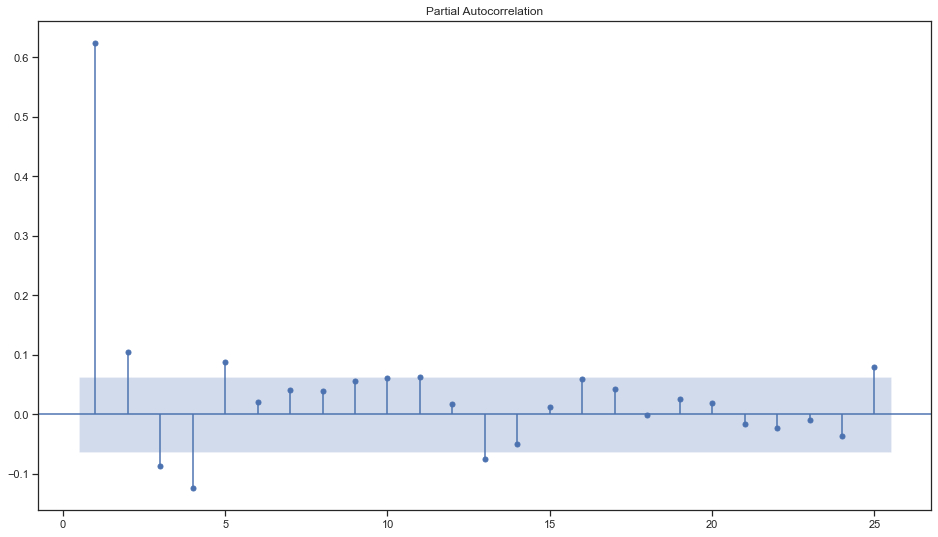

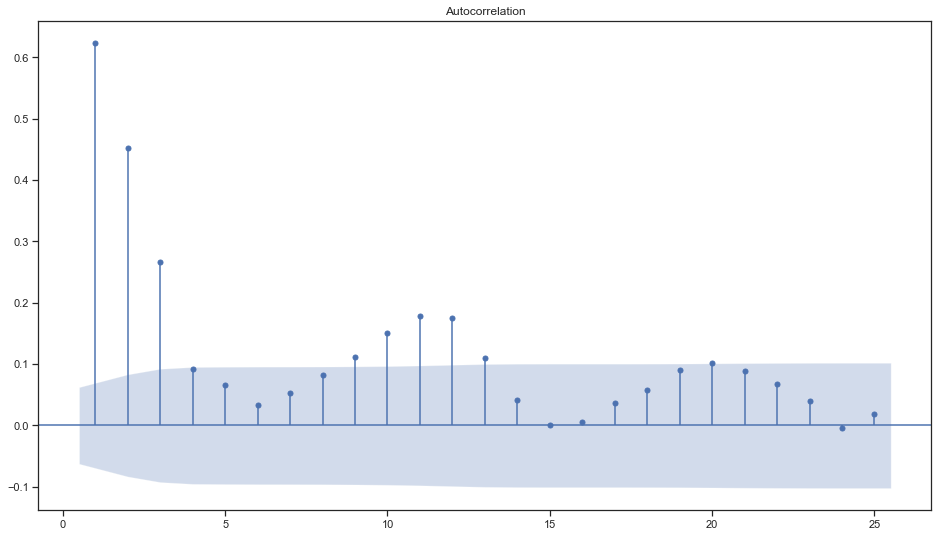

In [357]:
pacf = plot_pacf(block1_con["separator_pwr_kw_pv"], lags=25, zero=False)
acf = plot_acf(block1_con["separator_pwr_kw_pv"], lags=25, zero=False)

In [358]:
from pmdarima.arima.utils import ndiffs

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(block2_con["mill_dp_mbar_pv"], test='adf')  # -> 0
n_adf

0

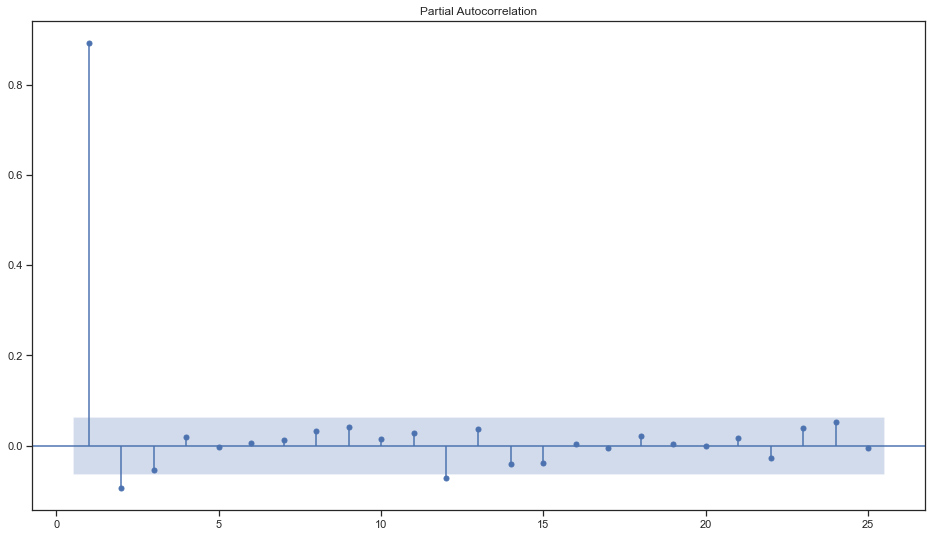

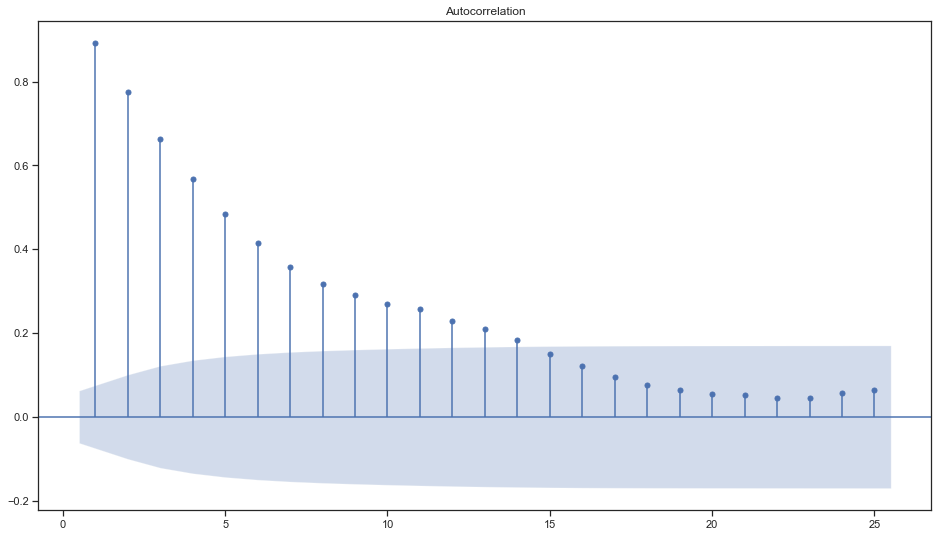

In [359]:
pacf = plot_pacf(block2_con["mill_dp_mbar_pv"], lags=25, zero=False)
acf = plot_acf(block2_con["mill_dp_mbar_pv"], lags=25, zero=False)

# Part 2: Machine Learning  - Forecasting

In [360]:
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

from sktime.forecasting.all import temporal_train_test_split, plot_series
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### 4.1 Forecasting Metrics:
**measure the prediction performance of the models.** 

* **R squared**: coefficient of determination (this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$  

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$  

sklearn.metrics.r2_score  
  
* **Mean Absolute Error**: this has the same unit of measurment as the initial series, $[0, +\infty)$  

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$  

sklearn.metrics.mean_absolute_error  
  
* **Root Mean Squared Error**: the most commonly used metric that gives a higher penalty to large errors and vice versa, this too has the same unit of measurment as the initial series $[0, +\infty)$  

$RMSE = \sqrt(\frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2)$  

np.sqrt(sklearn.metrics.mean_squared_error)    

* **Mean Absolute Percentage Error**: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$  

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$  

# Block1

In [361]:
# ///// Split the dataset into training part and test part ////////

y_train_block1, y_test_block1 = temporal_train_test_split(block1_con, test_size= 10)

y_train_block1.shape, y_test_block1.shape

((974, 3), (10, 3))

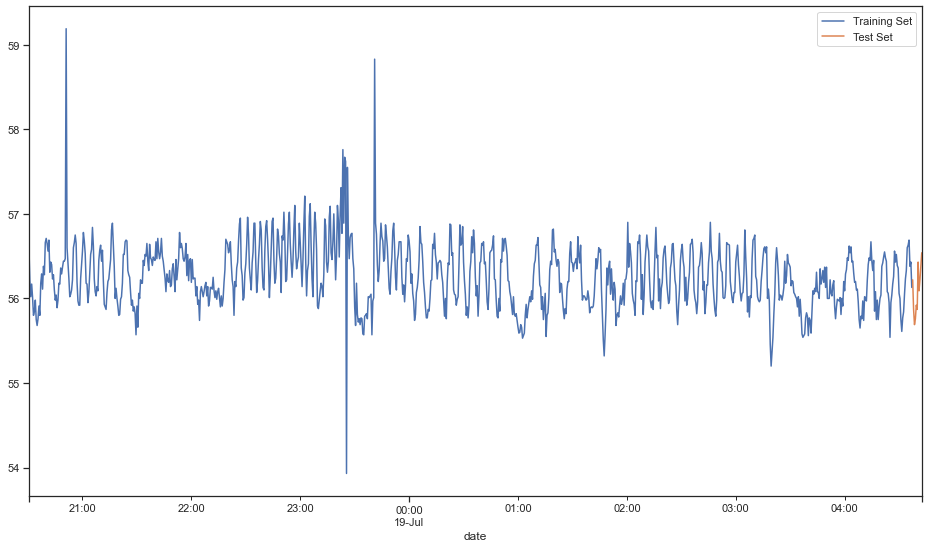

In [362]:
# ///////// Plotting the training dataset and the test dataset /////////

y_train_block1["separator_pwr_kw_pv"].plot(label= "Training Set")
y_test_block1["separator_pwr_kw_pv"].plot(label= "Test Set")
plt.legend()
plt.show()

In [374]:
# /////// Find the best hyperparameters  for Arima model  //////////

wise_fit = auto_arima(y_train_block1["separator_pwr_kw_pv"],
                      trace= True,
                      m=20,
                      max_P=5,
                      max_Q=5,
                      suppress_warnings = True,
                      seasonal=True,
                      stationary=True,
                      exogenous = y_train_block1[["separator_speed_rpm_pv", "mill_dp_mbar_pv"]])
wise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[20] intercept   : AIC=736.133, Time=5.98 sec
 ARIMA(0,0,0)(0,0,0)[20] intercept   : AIC=1502.289, Time=0.33 sec
 ARIMA(1,0,0)(1,0,0)[20] intercept   : AIC=759.004, Time=2.83 sec
 ARIMA(0,0,1)(0,0,1)[20] intercept   : AIC=1113.869, Time=2.88 sec
 ARIMA(0,0,0)(0,0,0)[20]             : AIC=1529.205, Time=0.63 sec
 ARIMA(2,0,2)(0,0,1)[20] intercept   : AIC=733.732, Time=2.79 sec
 ARIMA(2,0,2)(0,0,0)[20] intercept   : AIC=722.666, Time=0.49 sec
 ARIMA(2,0,2)(1,0,0)[20] intercept   : AIC=696.051, Time=6.62 sec
 ARIMA(2,0,2)(2,0,0)[20] intercept   : AIC=739.440, Time=17.86 sec
 ARIMA(2,0,2)(2,0,1)[20] intercept   : AIC=738.730, Time=22.23 sec
 ARIMA(1,0,2)(1,0,0)[20] intercept   : AIC=737.131, Time=3.54 sec
 ARIMA(2,0,1)(1,0,0)[20] intercept   : AIC=724.480, Time=8.95 sec
 ARIMA(3,0,2)(1,0,0)[20] intercept   : AIC=767.623, Time=9.76 sec
 ARIMA(2,0,3)(1,0,0)[20] intercept   : AIC=661.255, Time=5.44 sec
 ARIMA(2,0,3)(0,0,0)[20] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  974
Model:             SARIMAX(2, 0, 4)x(2, 0, [1], 20)   Log Likelihood                -168.898
Date:                              Sun, 18 Apr 2021   AIC                            363.797
Time:                                      19:30:37   BIC                            427.255
Sample:                                  07-18-2019   HQIC                           387.946
                                       - 07-19-2019                                         
Covariance Type:                                opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                  0.9354      1.793      0.522      0.602      -2.579       4.450
separator_speed_rpm_pv    -0.0105      0.003     -3.542      0.000      -0.016      -0.005
mill_dp_mbar_pv            0.0050      0.036      0.137      0.891      -0.066       0.076
ar.L1                      1.1715      0.155      7.552      0.000       0.867       1.476
ar.L2                     -0.1923      0.143     -1.340      0.180      -0.473       0.089
ma.L1                     -0.5667      0.154     -3.669      0.000      -0.869      -0.264
ma.L2                      0.0381      0.062      0.613      0.540      -0.084       0.160
ma.L3                     -0.1249      0.033     -3.838      0.000      -0.189      -0.061
ma.L4                     -0.1861      0.039     -4.797      0.000      -0.262      -0.110
ar.S.L20                   0.2704      1.244      0.217      0.828      -2.167       2.708
ar.S.L40                   0.0217      0.059      0.369      0.712      -0.094       0.137
ma.S.L20                  -0.2370      1.242     -0.191      0.849      -2.671       2.197
sigma2                     0.0827      0.001     57.125      0.000       0.080       0.086
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):             66812.65
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX

In [375]:
#/////// I use SARIMAX in order to insert the Trend and Seasonality parameters into the model /////////

model1 = SARIMAX(y_train_block1["separator_pwr_kw_pv"],
                 order=(2,0,4),
                 seasonal_order=(2,0,1,20),
                 exog= y_train_block1[["separator_speed_rpm_pv", "mill_dp_mbar_pv"]],
                 trend="n")
model1_fit=model1.fit(disp=False)
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                  separator_pwr_kw_pv   No. Observations:                  974
Model:             SARIMAX(2, 0, 4)x(2, 0, [1], 20)   Log Likelihood                -331.185
Date:                              Sun, 18 Apr 2021   AIC                            686.371
Time:                                      20:30:39   BIC                            744.948
Sample:                                  07-18-2019   HQIC                           708.663
                                       - 07-19-2019                                         
Covariance Type:                                opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
separator_speed_rpm_pv     0.0651      0.001     51.662      0.000       0.063       0.068
mill_dp_mbar_pv            0.2669      0.028      9.529      0.000       0.212       0.322
ar.L1                      1.2124      0.166      7.290      0.000       0.886       1.538
ar.L2                     -0.2339      0.156     -1.501      0.133      -0.539       0.071
ma.L1                     -0.5804      0.164     -3.540      0.000      -0.902      -0.259
ma.L2                      0.0388      0.062      0.623      0.534      -0.083       0.161
ma.L3                     -0.1606      0.024     -6.708      0.000      -0.208      -0.114
ma.L4                     -0.1049      0.038     -2.765      0.006      -0.179      -0.031
ar.S.L20                   0.2134      8.684      0.025      0.980     -16.806      17.233
ar.S.L40                   0.0103      0.185      0.056      0.956      -0.352       0.373
ma.S.L20                  -0.2350      8.681     -0.027      0.978     -17.250      16.780
sigma2                     0.1296      0.003     48.680      0.000       0.124       0.135
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):             46823.43
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [376]:
start = len(y_train_block1)
end = len(y_train_block1)+ len(y_test_block1)-1
pred1 = model1_fit.predict(start=start,
                           end= end,
                           typ= "levels",
                           exog=y_test_block1[["separator_speed_rpm_pv", "mill_dp_mbar_pv"]])
pred1_train = model1_fit.predict(start = 0,
                                end = len(y_train_block1) - 1,
                                typ= "levels",
                                exog=y_test_block1[["separator_speed_rpm_pv", "mill_dp_mbar_pv"]])
print(pred1)

2019-07-19 04:37:30    56.133507
2019-07-19 04:38:00    56.130325
2019-07-19 04:38:30    56.152744
2019-07-19 04:39:00    56.197064
2019-07-19 04:39:30    56.322106
2019-07-19 04:40:00    56.236835
2019-07-19 04:40:30    56.281471
2019-07-19 04:41:00    56.136384
2019-07-19 04:41:30    56.173439
2019-07-19 04:42:00    56.185494
Freq: 30S, Name: predicted_mean, dtype: float64


In [377]:
rmse = sqrt(mean_squared_error(y_test_block1["separator_pwr_kw_pv"], pred1))

print("MSE:", mean_squared_error(y_test_block1["separator_pwr_kw_pv"], pred1))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_test_block1["separator_pwr_kw_pv"], pred1))

MSE: 0.09287181261450317
RMSE: 0.3047487696685635
MAE: 0.261154658860174


In [378]:
rmse = sqrt(mean_squared_error(y_train_block1["separator_pwr_kw_pv"], pred1_train))

print("MSE:", mean_squared_error(y_train_block1["separator_pwr_kw_pv"], pred1_train))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_train_block1["separator_pwr_kw_pv"], pred1_train))

MSE: 0.11467616887612392
RMSE: 0.3386386996137977
MAE: 0.2125628459561886


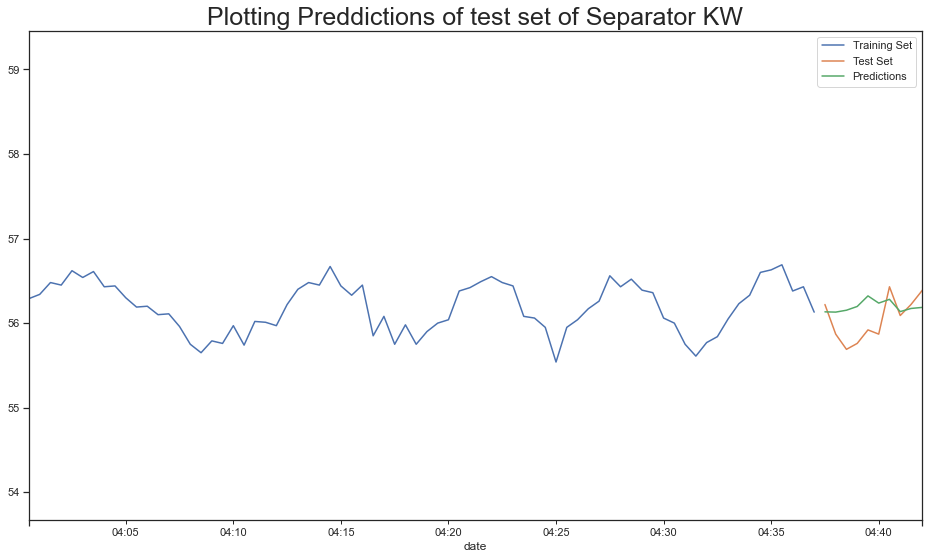

In [379]:
y_train_block1["separator_pwr_kw_pv"].plot(label= "Training Set")
y_test_block1["separator_pwr_kw_pv"].plot(label= "Test Set")
pred1.plot(label= "Predictions")
plt.xlim("2019-07-19 04:00:30" , "2019-07-19 04:42:00 ")
plt.title("Plotting Preddictions of test set of Separator KW", fontsize=25)
plt.legend()
plt.show()

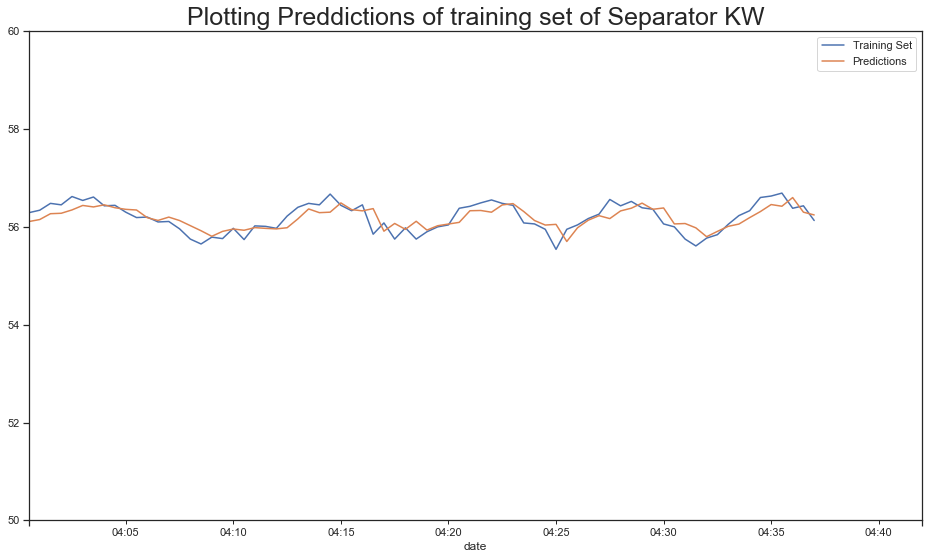

In [380]:
y_train_block1["separator_pwr_kw_pv"].plot(label= "Training Set")
pred1_train.plot(label= "Predictions")
plt.xlim("2019-07-19 04:00:30" , "2019-07-19 04:42:00 ")
plt.title("Plotting Preddictions of training set of Separator KW", fontsize=25)
plt.ylim(50,60)
plt.legend()
plt.show()

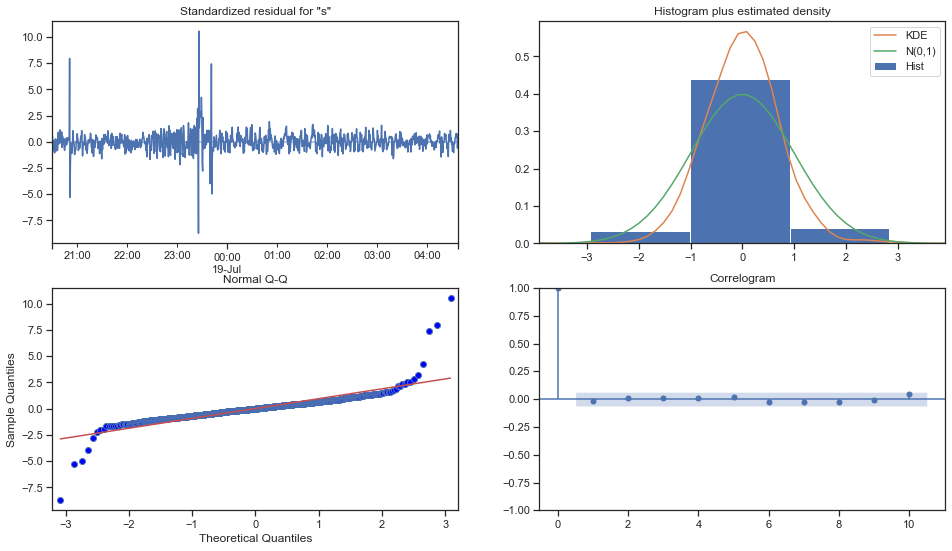

In [381]:
model1_fit.plot_diagnostics()
plt.show()

#### We want the first graph to have no seasonality, the second to have a normal distribution of the residuals and in the fourth to see the exist of the correlation of the residuals

In [125]:
#/////// I use SARIMAX in order to insert the Trend and Seasonality parameters into the model /////////

model1_final = SARIMAX(block1_con["separator_pwr_kw_pv"],
                 order=(0,1,6),
                 seasonal_order=(0,1,6,20),
                 exog= block1_con[["separator_speed_rpm_pv", "mill_dp_mbar_pv"]],
                 trend="n")
model1_final_fit=model1_final.fit(disp=False)
model1_final_fit.summary()

C:\Users\Intel PC G5900\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Intel PC G5900\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Intel PC G5900\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                separator_pwr_kw_pv   No. Observations:                  984
Model:             SARIMAX(0, 1, 6)x(0, 1, 6, 20)   Log Likelihood                -196.242
Date:                            Sun, 18 Apr 2021   AIC                            422.484
Time:                                    00:39:53   BIC                            495.535
Sample:                                         0   HQIC                           450.299
                                            - 984                                         
Covariance Type:                              opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
separator_speed_rpm_pv    -0.0038      0.003     -1.444      0.149      -0.009       0.001
mill_dp_mbar_pv            0.0138      0.033      0.412      0.680      -0.052       0.079
ma.L1                     -0.4422      0.022    -19.806      0.000      -0.486      -0.398
ma.L2                     -0.0738      0.032     -2.302      0.021      -0.137      -0.011
ma.L3                     -0.1328      0.029     -4.634      0.000      -0.189      -0.077
ma.L4                     -0.2478      0.031     -8.044      0.000      -0.308      -0.187
ma.L5                     -0.0139      0.033     -0.420      0.675      -0.079       0.051
ma.L6                     -0.0657      0.035     -1.871      0.061      -0.135       0.003
ma.S.L20                  -0.9633      0.053    -18.251      0.000      -1.067      -0.860
ma.S.L40                  -0.0327      0.038     -0.861      0.389      -0.107       0.042
ma.S.L60                   0.0171      0.039      0.438      0.661      -0.059       0.094
ma.S.L80                   0.0048      0.045      0.107      0.915      -0.083       0.092
ma.S.L100                  0.0035      0.048      0.073      0.942      -0.090       0.097
ma.S.L120                 -0.0065      0.034     -0.188      0.851      -0.074       0.061
sigma2                     0.0822      0.004     19.815      0.000       0.074       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             30230.36
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [131]:
y_train_block1

,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv
date,,,
2019-07-18 20:30:30,731.56,32.58,56.60
2019-07-18 20:31:00,730.77,32.81,56.21
2019-07-18 20:31:30,730.98,32.51,56.02
2019-07-18 20:32:00,731.14,32.72,56.17
2019-07-18 20:32:30,730.87,32.56,56.01
...,...,...,...
2019-07-19 04:35:00,730.71,32.58,56.63
2019-07-19 04:35:30,730.61,32.36,56.69
2019-07-19 04:36:00,730.40,32.78,56.38


In [132]:
block1_con.tail()

,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv
date,,,
2019-07-19 04:40:00,729.92,32.66,55.87
2019-07-19 04:40:30,730.56,32.67,56.43
2019-07-19 04:41:00,730.34,32.16,56.09
2019-07-19 04:41:30,730.56,32.23,56.22
2019-07-19 04:42:30,730.19,32.38,56.54


In [133]:
start = len(y_train_block1)+ len(y_test_block1)
end = len(y_train_block1)+ len(y_test_block1)-1 + 10
pred1_final = model1_final_fit.predict(start= start ,
                                 end= end,
                                 typ= "levels",
                                exog= y_test_block1[["separator_speed_rpm_pv", "mill_dp_mbar_pv"]])
pred1_final

C:\Users\Intel PC G5900\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


984    56.290294
985    56.264273
986    56.231505
987    56.186138
988    56.223096
989    56.230831
990    56.157858
991    56.207434
992    56.132980
993    56.103060
Name: predicted_mean, dtype: float64

In [134]:
pred1_final  = pred1_final.reset_index().drop("index", axis=1)
pred1_final

,predicted_mean
0,56.290294
1,56.264273
2,56.231505
3,56.186138
4,56.223096
5,56.230831
6,56.157858
7,56.207434
8,56.132980
9,56.103060


In [135]:
stamps = pd.date_range('2019-07-19 04:43:00', periods=10, freq='30s')
stamps

DatetimeIndex(['2019-07-19 04:43:00', '2019-07-19 04:43:30',
               '2019-07-19 04:44:00', '2019-07-19 04:44:30',
               '2019-07-19 04:45:00', '2019-07-19 04:45:30',
               '2019-07-19 04:46:00', '2019-07-19 04:46:30',
               '2019-07-19 04:47:00', '2019-07-19 04:47:30'],
              dtype='datetime64[ns]', freq='30S')

In [136]:
df = pd.DataFrame({'Date': stamps})
df

,Date
0,2019-07-19 04:43:00
1,2019-07-19 04:43:30
2,2019-07-19 04:44:00
3,2019-07-19 04:44:30
4,2019-07-19 04:45:00
5,2019-07-19 04:45:30
6,2019-07-19 04:46:00
7,2019-07-19 04:46:30
8,2019-07-19 04:47:00
9,2019-07-19 04:47:30


In [137]:
df_index = pd.merge(df,pred1_final, left_index=True, right_index=True)

df_index

,Date,predicted_mean
0,2019-07-19 04:43:00,56.290294
1,2019-07-19 04:43:30,56.264273
2,2019-07-19 04:44:00,56.231505
3,2019-07-19 04:44:30,56.186138
4,2019-07-19 04:45:00,56.223096
5,2019-07-19 04:45:30,56.230831
6,2019-07-19 04:46:00,56.157858
7,2019-07-19 04:46:30,56.207434
8,2019-07-19 04:47:00,56.132980
9,2019-07-19 04:47:30,56.103060


In [138]:
df_index = df_index.set_index("Date")
df_index

,predicted_mean
Date,
2019-07-19 04:43:00,56.290294
2019-07-19 04:43:30,56.264273
2019-07-19 04:44:00,56.231505
2019-07-19 04:44:30,56.186138
2019-07-19 04:45:00,56.223096
2019-07-19 04:45:30,56.230831
2019-07-19 04:46:00,56.157858
2019-07-19 04:46:30,56.207434
2019-07-19 04:47:00,56.132980


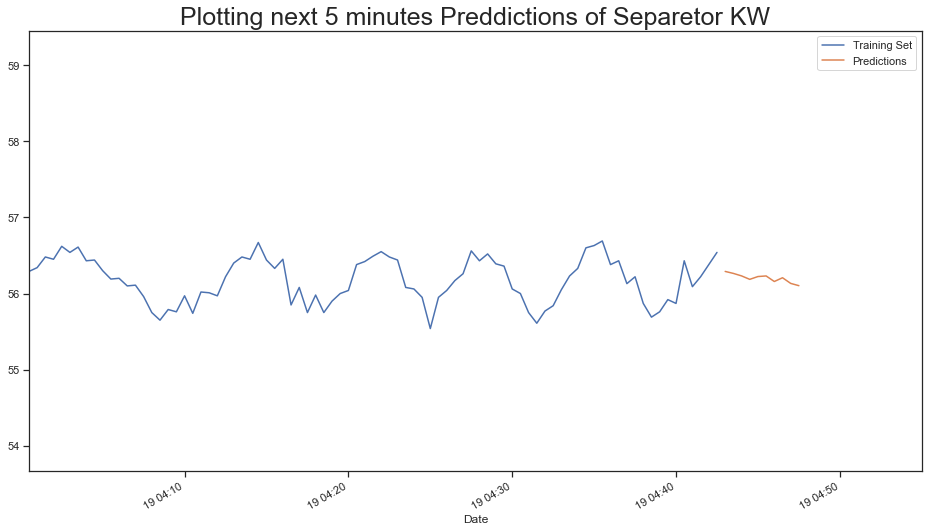

In [139]:
block1_con["separator_pwr_kw_pv"].plot(label= "Training Set")
df_index["predicted_mean"].plot(label= "Predictions")
plt.xlim("2019-07-19 04:00:30" , "2019-07-19 04:55:00 ")
plt.title("Plotting next 5 minutes Preddictions of Separetor KW", fontsize=25)
plt.legend()
plt.show()

# Block2

In [140]:
# ///// Split the dataset into training part and test part ////////

y_train_block2, y_test_block2 = temporal_train_test_split(block2_con, test_size= 10)

y_train_block2.shape, y_test_block2.shape

((974, 9), (10, 9))

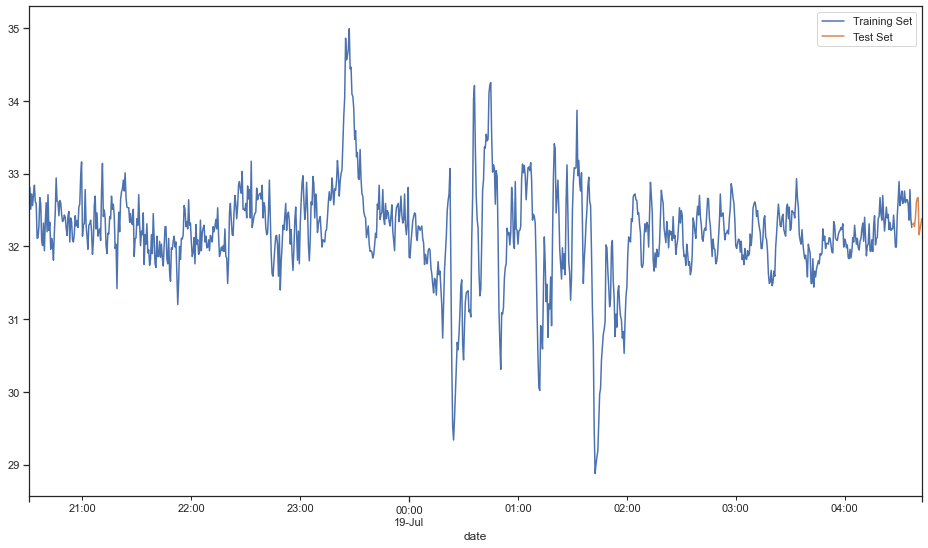

In [141]:
# ///////// Plotting the training dataset and the test dataset /////////

y_train_block2["mill_dp_mbar_pv"].plot(label= "Training Set")
y_test_block2["mill_dp_mbar_pv"].plot(label= "Test Set")
plt.legend()
plt.show()

## SARIMAX

In [144]:
#/////// I use SARIMAX in order to insert the Trend and Seasonality parameters into the model /////////

model2 = SARIMAX(y_train_block2["mill_dp_mbar_pv"],
                 order=(0,1,6),
                 seasonal_order=(0,1,6,20),
                 exog= y_train_block2[["total_feed_ton_h_pv",
                                       "fly_ash_1_perc_pv",
                                       "fly_ash_2_perc_pv",
                                       "fan_speed_rpm_pv",
                                       "separator_speed_rpm_pv",
                                       "grinding_pressure_bar_pv",
                                       "mill_injection_water_m3_h_pv",
                                       "bucket_elv_mtr_pwr_kw_pv"]],
                 trend="n")
model2_fit=model2.fit(disp=False)
model2_fit.summary()

C:\Users\Intel PC G5900\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 30S will be used.
  warnings.warn('No frequency information was'
C:\Users\Intel PC G5900\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 30S will be used.
  warnings.warn('No frequency information was'
C:\Users\Intel PC G5900\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    mill_dp_mbar_pv   No. Observations:                  974
Model:             SARIMAX(0, 1, 6)x(0, 1, 6, 20)   Log Likelihood                -248.642
Date:                            Sun, 18 Apr 2021   AIC                            539.284
Time:                                    01:35:54   BIC                            641.336
Sample:                                07-18-2019   HQIC                           578.162
                                     - 07-19-2019                                         
Covariance Type:                              opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
total_feed_ton_h_pv              0.0275      0.033      0.838      0.402      -0.037       0.092
fly_ash_1_perc_pv               -0.0263      0.032     -0.835      0.404      -0.088       0.035
fly_ash_2_perc_pv               -0.0130      0.033     -0.389      0.697      -0.078       0.052
fan_speed_rpm_pv             -3.019e-05   2973.943  -1.02e-08      1.000   -5828.821    5828.821
separator_speed_rpm_pv          -0.0059      0.007     -0.796      0.426      -0.020       0.009
grinding_pressure_bar_pv        -0.0058      0.004     -1.654      0.098      -0.013       0.001
mill_injection_water_m3_h_pv    -0.3868      1.625     -0.238      0.812      -3.571       2.798
bucket_elv_mtr_pwr_kw_pv        -0.0060      0.240     -0.025      0.980      -0.476       0.464
ma.L1                           -0.0086      0.022     -0.383      0.701      -0.052       0.035
ma.L2                           -0.0548      0.026     -2.104      0.035      -0.106      -0.004
ma.L3                           -0.1418      0.030     -4.776      0.000      -0.200      -0.084
ma.L4                           -0.1194      0.032     -3.777      0.000      -0.181      -0.057
ma.L5                           -0.0968      0.030     -3.250      0.001      -0.155      -0.038
ma.L6                           -0.0786      0.031     -2.538      0.011      -0.139      -0.018
ma.S.L20                        -1.0337      0.316     -3.274      0.001      -1.653      -0.415
ma.S.L40                        -0.0012      0.045     -0.028      0.978      -0.089       0.087
ma.S.L60                         0.0140      0.045      0.311      0.756      -0.074       0.102
ma.S.L80                         0.0327      0.045      0.727      0.467      -0.055       0.121
ma.S.L100                        0.0111      0.045      0.245      0.807      -0.078       0.100
ma.S.L120                       -0.0199      0.037     -0.540      0.589      -0.092       0.052
sigma2                           0.0909      0.029      3.162      0.002       0.035       0.147
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               177.26
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [145]:
start = len(y_train_block2)
end = len(y_train_block2)+ len(y_test_block2)-1
pred2 = model2_fit.predict(start=start,
                           end= end,
                           typ= "levels",
                           exog=y_test_block2[["total_feed_ton_h_pv",
                                               "fly_ash_1_perc_pv",
                                               "fly_ash_2_perc_pv",
                                               "fan_speed_rpm_pv",
                                               "separator_speed_rpm_pv",
                                               "grinding_pressure_bar_pv",
                                               "mill_injection_water_m3_h_pv",
                                               "bucket_elv_mtr_pwr_kw_pv"]])
pred2_train = model2_fit.predict(start = 0,
                                end = len(y_train_block1) - 1,
                                typ= "levels",
                                exog=y_test_block2[["total_feed_ton_h_pv",
                                                   "fly_ash_1_perc_pv",
                                                   "fly_ash_2_perc_pv",
                                                   "fan_speed_rpm_pv",
                                                   "separator_speed_rpm_pv",
                                                   "grinding_pressure_bar_pv",
                                                   "mill_injection_water_m3_h_pv",
                                                   "bucket_elv_mtr_pwr_kw_pv"]])
print(pred2)

2019-07-19 04:37:30    32.205440
2019-07-19 04:38:00    32.234938
2019-07-19 04:38:30    32.238251
2019-07-19 04:39:00    32.256207
2019-07-19 04:39:30    32.304098
2019-07-19 04:40:00    32.320696
2019-07-19 04:40:30    32.378306
2019-07-19 04:41:00    32.424059
2019-07-19 04:41:30    32.407309
2019-07-19 04:42:00    32.342077
Freq: 30S, Name: predicted_mean, dtype: float64


In [147]:
rmse = sqrt(mean_squared_error(y_test_block2["mill_dp_mbar_pv"], pred2))

print("MSE:", mean_squared_error(y_test_block2["mill_dp_mbar_pv"], pred2))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_test_block2["mill_dp_mbar_pv"], pred2))

MSE: 0.042546032685682585
RMSE: 0.20626689672771678
MAE: 0.1751355499704438


In [149]:
rmse = sqrt(mean_squared_error(y_train_block2["mill_dp_mbar_pv"], pred2_train))

print("MSE:", mean_squared_error(y_train_block2["mill_dp_mbar_pv"], pred2_train))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_train_block2["mill_dp_mbar_pv"], pred2_train))

MSE: 1.8371717543856423
RMSE: 1.3554230905461373
MAE: 0.2887991059281975


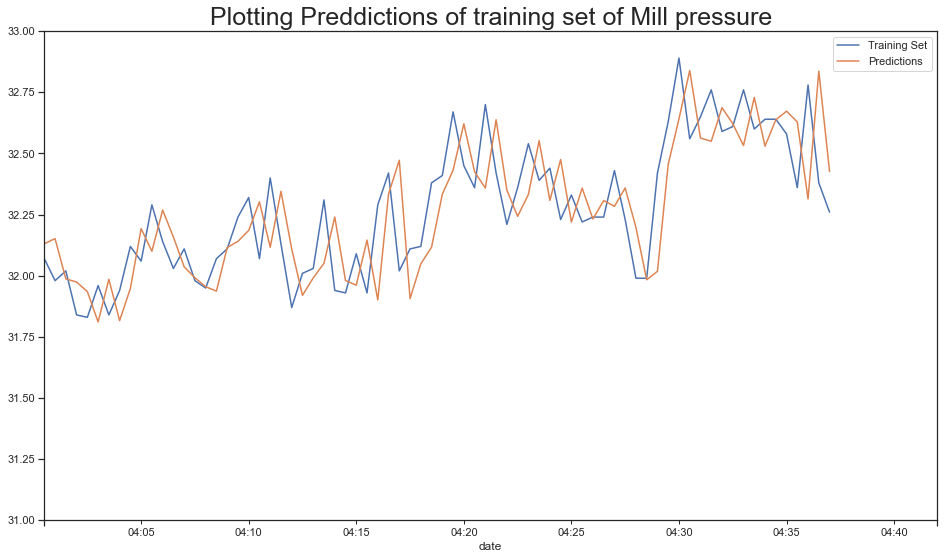

In [154]:
y_train_block2["mill_dp_mbar_pv"].plot(label= "Training Set")
pred2_train.plot(label= "Predictions")
plt.xlim("2019-07-19 04:00:30" , "2019-07-19 04:42:00 ")
plt.title("Plotting Preddictions of training set of Mill pressure", fontsize=25)
plt.ylim(31,33)
plt.legend()
plt.show()

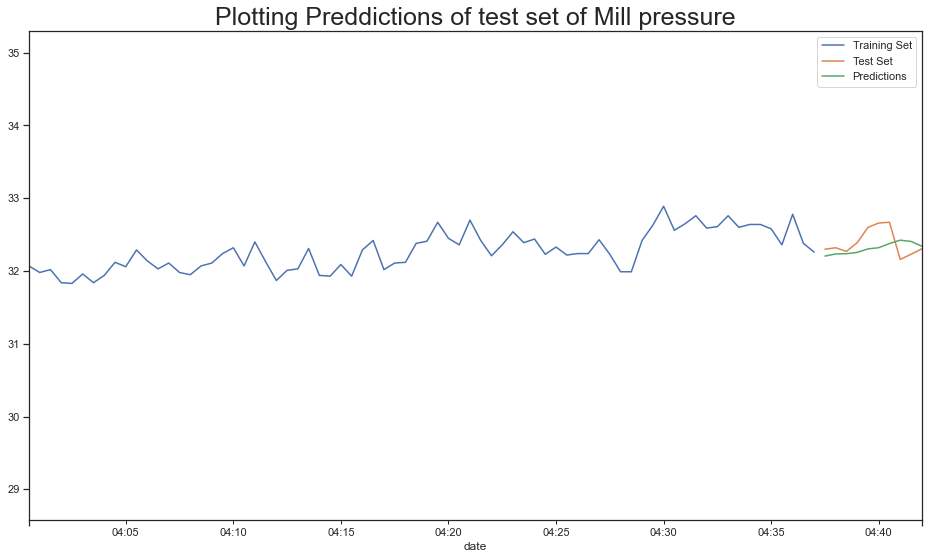

In [155]:
y_train_block2["mill_dp_mbar_pv"].plot(label= "Training Set")
y_test_block2["mill_dp_mbar_pv"].plot(label= "Test Set")
pred2.plot(label= "Predictions")
plt.xlim("2019-07-19 04:00:30" , "2019-07-19 04:42:00 ")
plt.title("Plotting Preddictions of test set of Mill pressure", fontsize=25)
plt.legend()
plt.show()

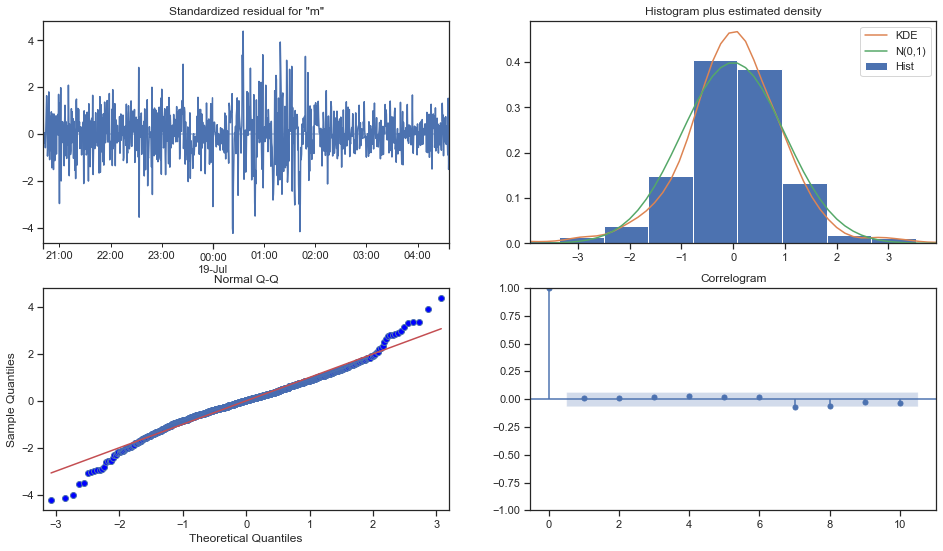

In [156]:
model2_fit.plot_diagnostics()
plt.show()

In [157]:
#/////// I use SARIMAX in order to insert the Trend and Seasonality parameters into the model /////////

model2_final = SARIMAX(block2_con["mill_dp_mbar_pv"],
                 order=(0,1,6),
                 seasonal_order=(0,1,6,20),
                 exog= block2_con[["total_feed_ton_h_pv",
                                    "fly_ash_1_perc_pv",
                                    "fly_ash_2_perc_pv",
                                    "fan_speed_rpm_pv",
                                    "separator_speed_rpm_pv",
                                    "grinding_pressure_bar_pv",
                                    "mill_injection_water_m3_h_pv",
                                    "bucket_elv_mtr_pwr_kw_pv"]],
                 trend="n")
model2_final_fit=model2_final.fit(disp=False)
model2_final_fit.summary()

C:\Users\Intel PC G5900\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Intel PC G5900\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Intel PC G5900\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    mill_dp_mbar_pv   No. Observations:                  984
Model:             SARIMAX(0, 1, 6)x(0, 1, 6, 20)   Log Likelihood                -248.118
Date:                            Sun, 18 Apr 2021   AIC                            538.236
Time:                                    02:09:04   BIC                            640.507
Sample:                                         0   HQIC                           577.177
                                            - 984                                         
Covariance Type:                              opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
total_feed_ton_h_pv              0.0265      0.032      0.816      0.414      -0.037       0.090
fly_ash_1_perc_pv               -0.0253      0.031     -0.813      0.416      -0.086       0.036
fly_ash_2_perc_pv               -0.0120      0.033     -0.363      0.717      -0.077       0.053
fan_speed_rpm_pv             -2.164e-05   2969.135  -7.29e-09      1.000   -5819.397    5819.397
separator_speed_rpm_pv          -0.0059      0.007     -0.799      0.424      -0.020       0.009
grinding_pressure_bar_pv        -0.0054      0.003     -1.548      0.122      -0.012       0.001
mill_injection_water_m3_h_pv    -0.3654      1.608     -0.227      0.820      -3.518       2.787
bucket_elv_mtr_pwr_kw_pv         0.0434      0.238      0.182      0.856      -0.424       0.510
ma.L1                           -0.0060      0.022     -0.270      0.787      -0.050       0.038
ma.L2                           -0.0544      0.026     -2.102      0.036      -0.105      -0.004
ma.L3                           -0.1393      0.029     -4.728      0.000      -0.197      -0.082
ma.L4                           -0.1166      0.031     -3.721      0.000      -0.178      -0.055
ma.L5                           -0.0989      0.030     -3.341      0.001      -0.157      -0.041
ma.L6                           -0.0775      0.031     -2.518      0.012      -0.138      -0.017
ma.S.L20                        -1.0240      0.085    -12.076      0.000      -1.190      -0.858
ma.S.L40                        -0.0047      0.043     -0.110      0.912      -0.088       0.079
ma.S.L60                         0.0131      0.044      0.299      0.765      -0.073       0.099
ma.S.L80                         0.0344      0.044      0.787      0.431      -0.051       0.120
ma.S.L100                        0.0099      0.045      0.222      0.825      -0.078       0.097
ma.S.L120                       -0.0186      0.034     -0.540      0.589      -0.086       0.049
sigma2                           0.0910      0.008     11.700      0.000       0.076       0.106
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               182.07
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
start = len(y_train_block2)+ len(y_test_block2)
end = len(y_train_block2)+ len(y_test_block2)-1 + 10
pred2_final = model2_final_fit.predict(start= start ,
                                 end= end,
                                 typ= "levels",
                                exog= y_test_block2[["total_feed_ton_h_pv",
                                                    "fly_ash_1_perc_pv",
                                                    "fly_ash_2_perc_pv",
                                                    "fan_speed_rpm_pv",
                                                    "separator_speed_rpm_pv",
                                                    "grinding_pressure_bar_pv",
                                                    "mill_injection_water_m3_h_pv",
                                                    "bucket_elv_mtr_pwr_kw_pv"]])
pred2_final

C:\Users\Intel PC G5900\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


984    32.488550
985    32.484835
986    32.472797
987    32.406019
988    32.428624
989    32.446210
990    32.513461
991    32.496519
992    32.542364
993    32.525824
Name: predicted_mean, dtype: float64

In [159]:
pred2_final  = pred2_final.reset_index().drop("index", axis=1)
pred2_final

,predicted_mean
0,32.488550
1,32.484835
2,32.472797
3,32.406019
4,32.428624
5,32.446210
6,32.513461
7,32.496519
8,32.542364
9,32.525824


In [165]:
df2_index = pd.merge(df,pred2_final, left_index=True, right_index=True)

df2_index

,Date,predicted_mean
0,2019-07-19 04:43:00,32.488550
1,2019-07-19 04:43:30,32.484835
2,2019-07-19 04:44:00,32.472797
3,2019-07-19 04:44:30,32.406019
4,2019-07-19 04:45:00,32.428624
5,2019-07-19 04:45:30,32.446210
6,2019-07-19 04:46:00,32.513461
7,2019-07-19 04:46:30,32.496519
8,2019-07-19 04:47:00,32.542364
9,2019-07-19 04:47:30,32.525824


In [167]:
df2_index = df2_index.set_index("Date")
df2_index

,predicted_mean
Date,
2019-07-19 04:43:00,32.488550
2019-07-19 04:43:30,32.484835
2019-07-19 04:44:00,32.472797
2019-07-19 04:44:30,32.406019
2019-07-19 04:45:00,32.428624
2019-07-19 04:45:30,32.446210
2019-07-19 04:46:00,32.513461
2019-07-19 04:46:30,32.496519
2019-07-19 04:47:00,32.542364


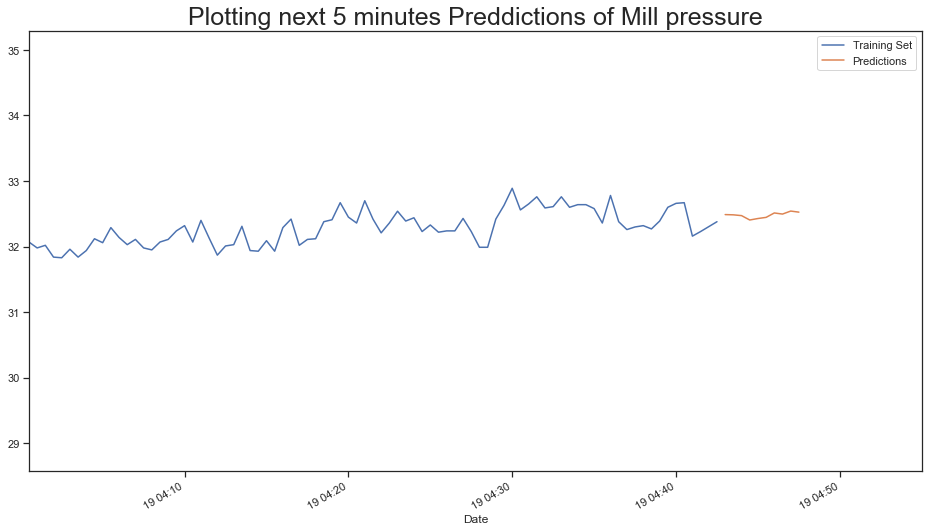

In [168]:
block2_con["mill_dp_mbar_pv"].plot(label= "Training Set")
df2_index["predicted_mean"].plot(label= "Predictions")
plt.xlim("2019-07-19 04:00:30" , "2019-07-19 04:55:00 ")
plt.title("Plotting next 5 minutes Preddictions of Mill pressure", fontsize=25)
plt.legend()
plt.show()